In [1]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from distributed import LocalCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.cm as cm
import scipy.stats as st

In [3]:
large = 20; med = 16; small = 12
params = {'axes.titlesize': med,
          'legend.fontsize': small,
          'axes.labelsize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med,
          "font.family": "serif"}
plt.rcParams.update(params)

In [ ]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='1000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(10)

In [ ]:
client = Client(cluster)

In [ ]:
client.retire_workers()

In [ ]:
client

In [3]:
files = [f for f in glob.glob("../instance_files/createdb_iceagg_rand*")]

In [4]:
%%time 
    
data = []
for file in files:
    print(file)
    data.append(pd.read_pickle(file, None))
datapd = [pd.DataFrame(i) for i in data]
df_rand = pd.concat(datapd, axis=0, ignore_index=True)
count_all = df_rand.count()
    
#speed up shape function 
vfunc = np.vectorize(shape)
df_rand = df_rand.reset_index()
df_rand['shape'] = vfunc(df_rand['a'], df_rand['b'], df_rand['c'])
df_rand.loc[df_rand['shape'] == 'oblate', 'agg_r'] = np.power((np.power(df_rand['a'], 2) * df_rand['c']), (1./3.))
df_rand.loc[df_rand['shape'] == 'prolate', 'agg_r'] = np.power((np.power(df_rand['c'], 2) * df_rand['a']), (1./3.))
df_rand = df_rand[df_rand.agg_r < 5000]
count_less5 =df_rand.count()
perc = (count_less5/count_all)*100
df_rand['agg_phi'] = df_rand.c/df_rand.a

../instance_files/createdb_iceagg_rand_r500_1000
../instance_files/createdb_iceagg_rand_r1_5
../instance_files/createdb_iceagg_rand_r6_10
../instance_files/createdb_iceagg_rand_r20_70
../instance_files/createdb_iceagg_rand_r80_400
CPU times: user 1min 13s, sys: 19.5 s, total: 1min 33s
Wall time: 3min 34s


In [4]:
files = [f for f in glob.glob("../instance_files/createdb_iceagg_flat*")]

In [7]:
def shape(a,b,c):
    if (b-c) <= (a-b):
        return 'prolate'
    else:
        return 'oblate'

In [8]:
%%time 
data = []
for file in files:
    print(file)
    data.append(pd.read_pickle(file, None))
datapd = [pd.DataFrame(i) for i in data]
df_flat = pd.concat(datapd, axis=0, ignore_index=True)
df_flat = df_flat.reset_index()
vfunc = np.vectorize(shape)
df_flat['shape'] = vfunc(df_flat['a'], df_flat['b'], df_flat['c'])
df_flat.loc[df_flat['shape'] == 'oblate', 'agg_r'] = np.power((np.power(df_flat['a'], 2) * df_flat['c']), (1./3.))
df_flat.loc[df_flat['shape'] == 'prolate', 'agg_r'] = np.power((np.power(df_flat['c'], 2) * df_flat['a']), (1./3.))
df_flat = df_flat[df_flat.agg_r < 5000]
#count_less5 =df_flat.count()
#perc = (count_less5/count_all)*100
#print(count_less5, count_all, perc)
df_flat['agg_phi'] = df_flat.c/df_flat.a

../instance_files/createdb_iceagg_flat_r500_1000
../instance_files/createdb_iceagg_flat_r90_400
../instance_files/createdb_iceagg_flat_r40_80
../instance_files/createdb_iceagg_flat_r10_30
../instance_files/createdb_iceagg_flat_r1_4
../instance_files/createdb_iceagg_flat_r5_9
CPU times: user 1min 49s, sys: 13 s, total: 2min 2s
Wall time: 2min 5s


In [ ]:
df['agg_r'] = df['agg_r'][df.agg_r < 5000]
stats = df['agg_r'].describe().round(2)
stats
#78% of db

# MAIN

In [9]:
rand_orient = False     #randomly orient the seed crystal and new crystal: uses first random orientation
phi_factor=10
r_factor=2
agg_phi_bins = 20
agg_r_bins = 20
nclusters = 3

In [ ]:
phi_factor=10
r_factor=2
phi_range = np.logspace(np.log(1.0/phi_factor)/np.log(10),
                                        np.log(1.0*phi_factor)/np.log(10), 20)
r_range = np.logspace(np.log(100/r_factor)/np.log(10),\
                                      np.log(100*r_factor)/np.log(10),20)
print(phi_range)
print(r_range)

In [15]:
def main():
    if rand_orient:
        df=df_rand
    else:
        df=df_flat
    output = np.empty((agg_phi_bins,agg_r_bins),dtype=object)
    hold_clusters  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    a  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    c = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)

    res, phi_bins = pd.qcut(df.agg_phi, agg_phi_bins, retbins=True)

    for i in range(0,agg_phi_bins,2):
        print('agg phi range: ', phi_bins[i], phi_bins[i+1])
        #return a df that only queries within an aspect ratio bin
        df_phi = df[(df.agg_phi > phi_bins[i]) & (df.agg_phi < phi_bins[i+1])]  
        #to ensure at least 2 crystals within agg since ncrystals=1 not in db
        #now break that aspect ratio bin into 20 equal r bins
        
        res, r_bins = pd.qcut(df_phi.agg_r, agg_r_bins, retbins=True)
        for r in range(1): #agg r
               
            #print('r = ', r_bins[r], r_bins[r+1])
            df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
            #print(df_r.count())
            #plt.hist(df_r.mono_phi)
            #plt.xscale('log')
            #plt.show()

            samples = df_r.sample(nclusters)
            for n, agg in enumerate(samples.itertuples()):
                print('agg mono phi', agg.mono_phi)
                phi_range = np.logspace(np.log(agg.mono_phi/phi_factor)/np.log(10),
                                        np.log(agg.mono_phi*phi_factor)/np.log(10), 20)
                mono_phi = random.choice(phi_range)
                mono_phi = 0.01 if mono_phi < 0.01 else mono_phi
                mono_phi = 70 if mono_phi > 70 else mono_phi

                r_range = np.logspace(np.log(agg.mono_r/r_factor)/np.log(10),\
                                      np.log(agg.mono_r*r_factor)/np.log(10),20)
                mono_r = random.choice(r_range)
                mono_r = 1000 if mono_r>1000 else mono_r
                mono_r = 1 if mono_r<1 else mono_r
                
                a[i,r,n] = (mono_r ** 3 / mono_phi) ** (1. / 3.)
                c[i,r,n] = mono_phi * a[i,r,n]
#               print('phi range', agg.mono_phi, phi_range[0], phi_range[-1], phi_range)
#               print('r range: ', agg.mono_r, r_range[0], r_range[-1], r_range)
                
                hold_clusters[i,r,n] = ipas.Cluster_Calculations(agg)
                

            ipas.collect_clusters(a[i,r,:], c[i,r,:], hold_clusters[i,r,:], rand_orient=rand_orient)
            #output[i,r] = dask.delayed(ipas.collect_clusters)(a[i,r,:], c[i,r,:],
            #                                                     hold_clusters[i,r,:], rand_orient=rand_orient)

    return output, hold_clusters
    

In [16]:
def compute():
    agg_as = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    agg_bs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rzs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    phi2Ds = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cplxs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    dds = np.empty((agg_phi_bins, agg_r_bins, nclusters))

    gather = client.compute([*output.tolist()]) 
    gather = client.gather(gather)
    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dds = gather[:,:,5,:]

    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds

agg phi range:  0.004577826030975812 0.0279419543277127
agg mono phi 0.01
agg mono phi 0.01
agg mono phi 61.584821106602604
ar 1.125877999845912 Ap 4586.375645677951 Ac 4073.5991344583017 P 269.5435487997915
C 0.40506972198415697


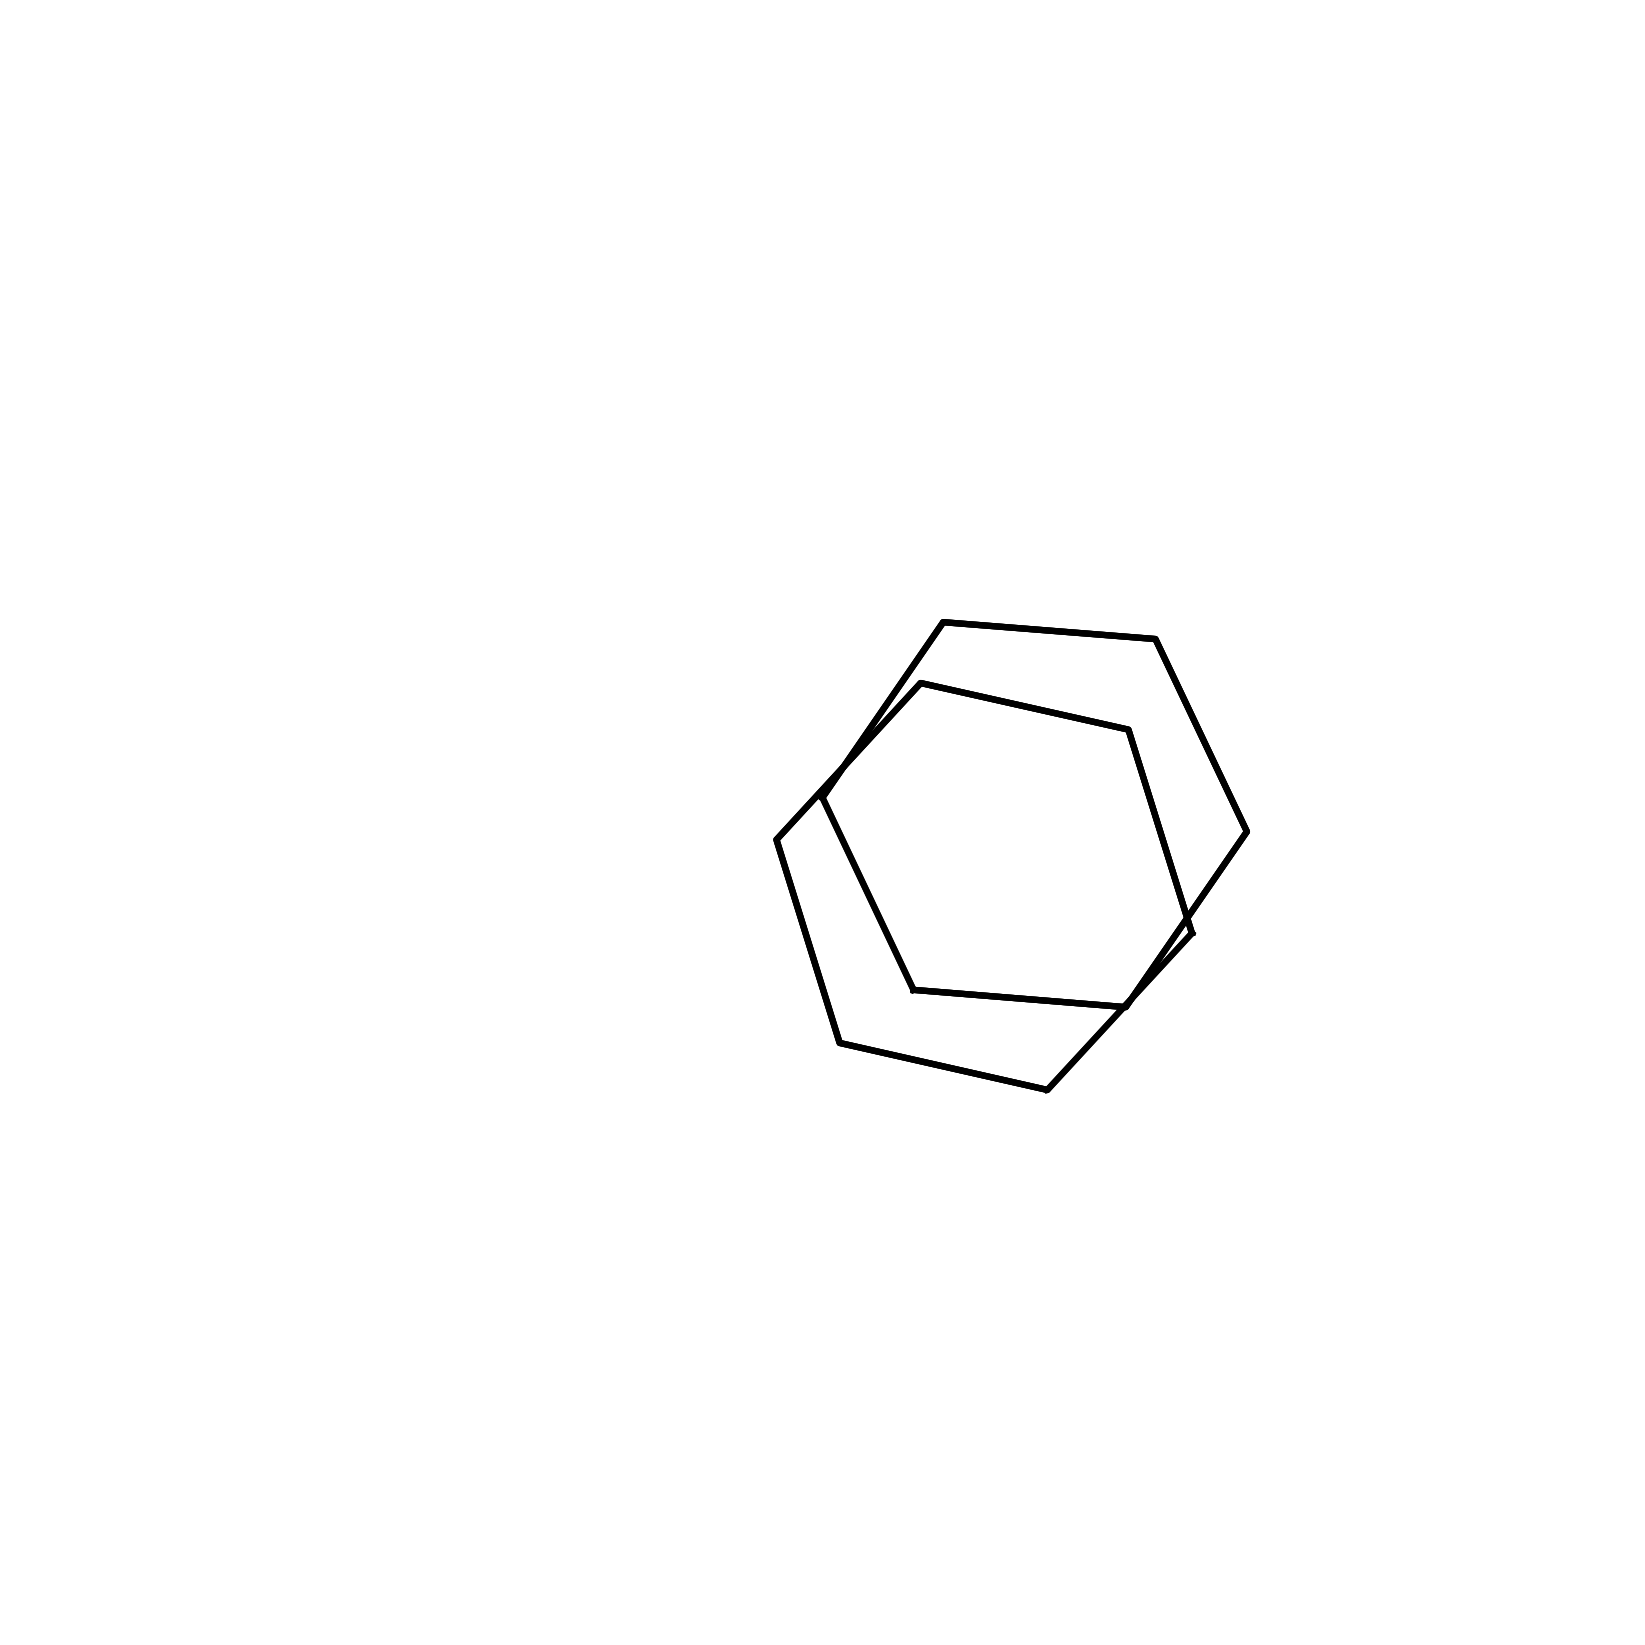

ar 0.8645406120594885 Ap 318.36185445139796 Ac 368.2439552411584 P 100.70703439107432
C 0.6623951228291735


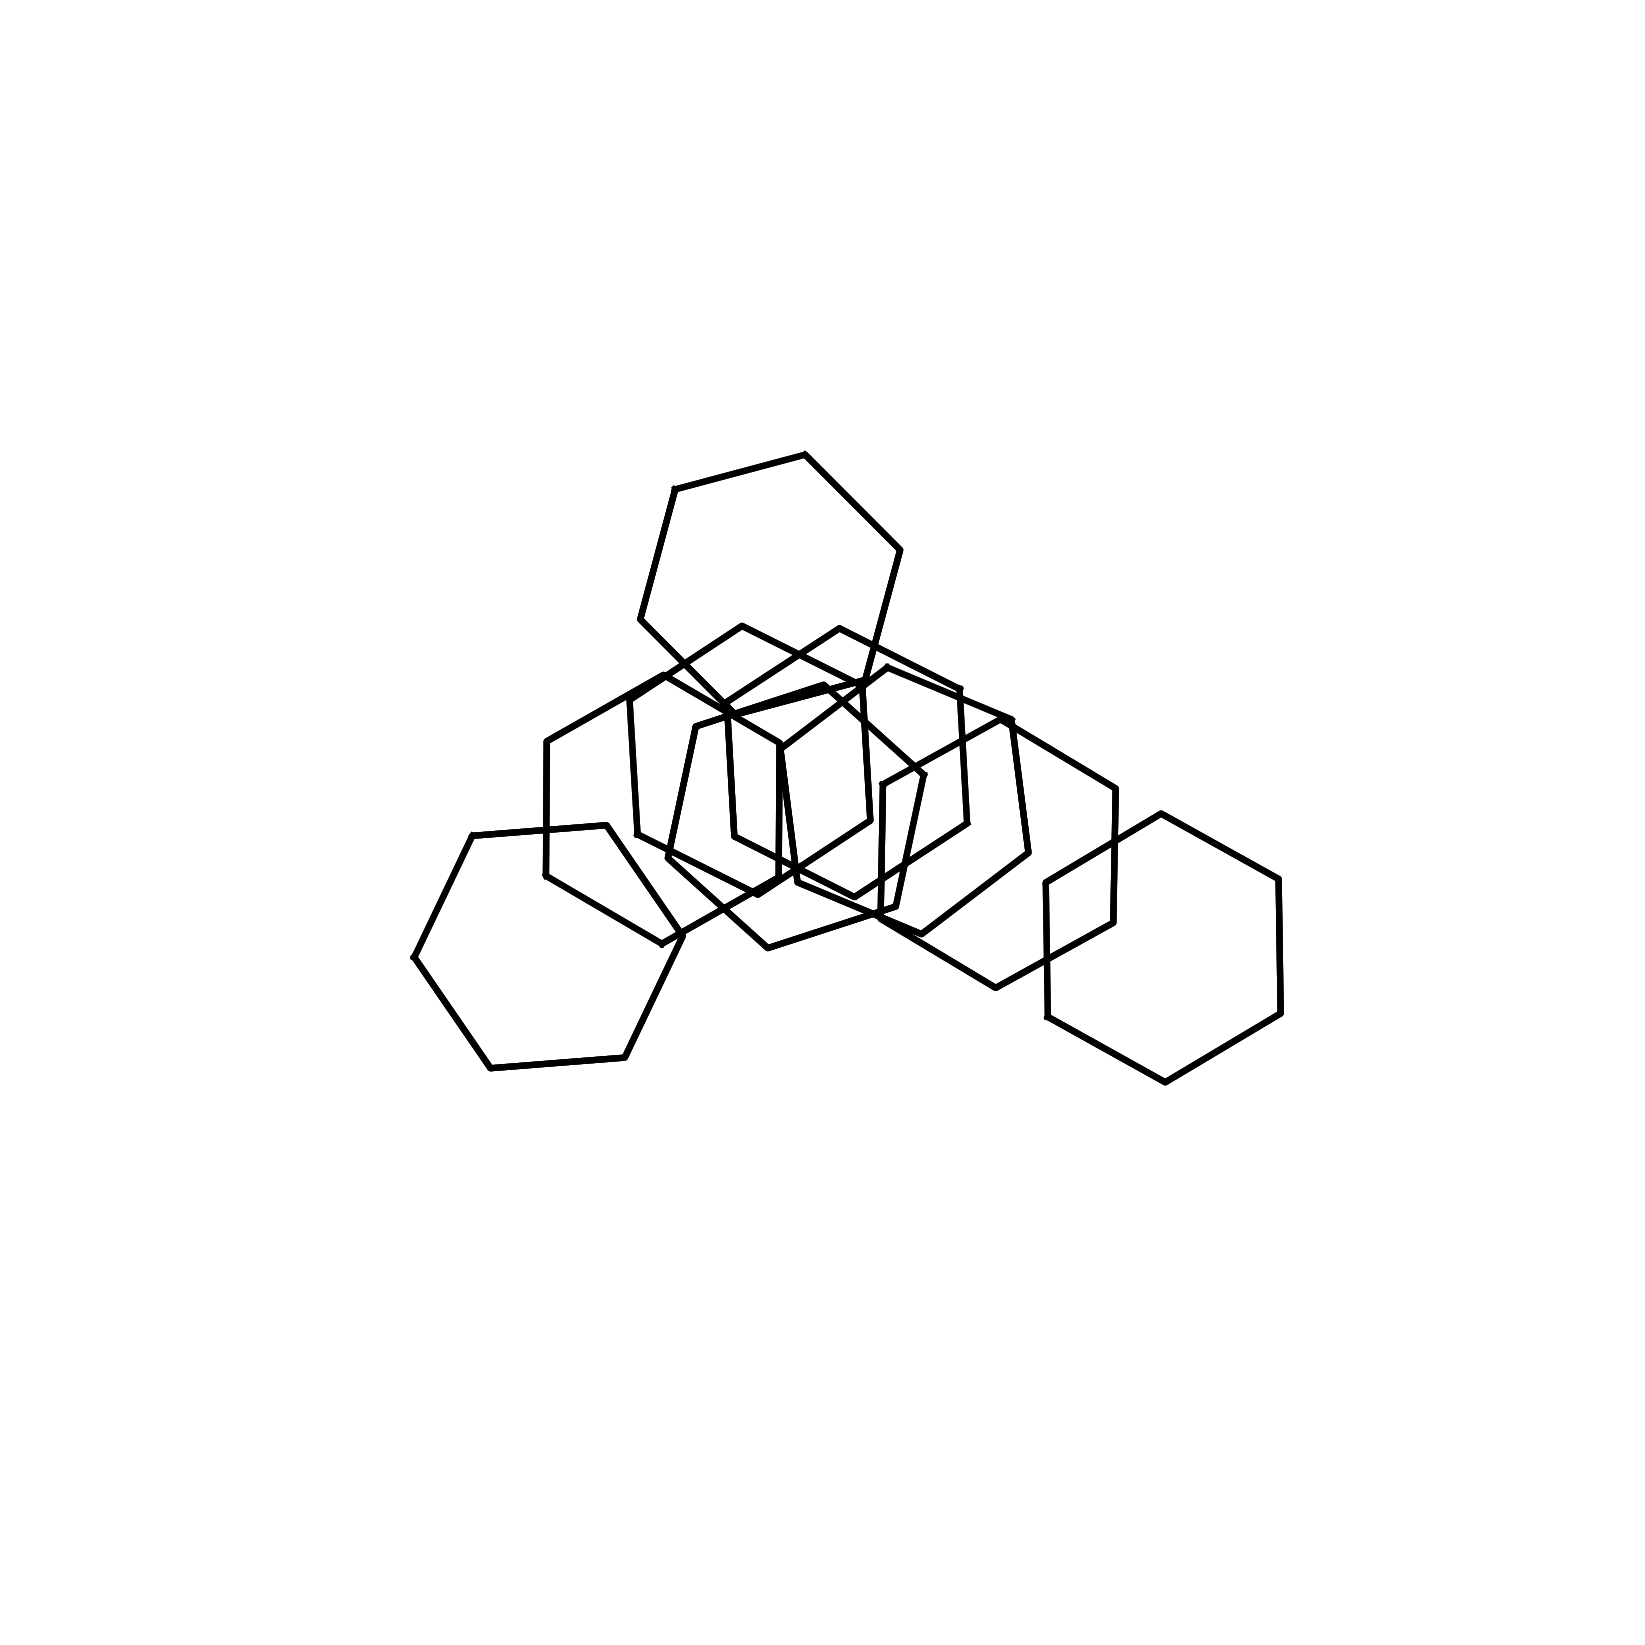

ar 0.039761971079863886 Ap 123.45961093598416 Ac 3104.9670723820363 P 484.56506261124
C 0.9736314192404503


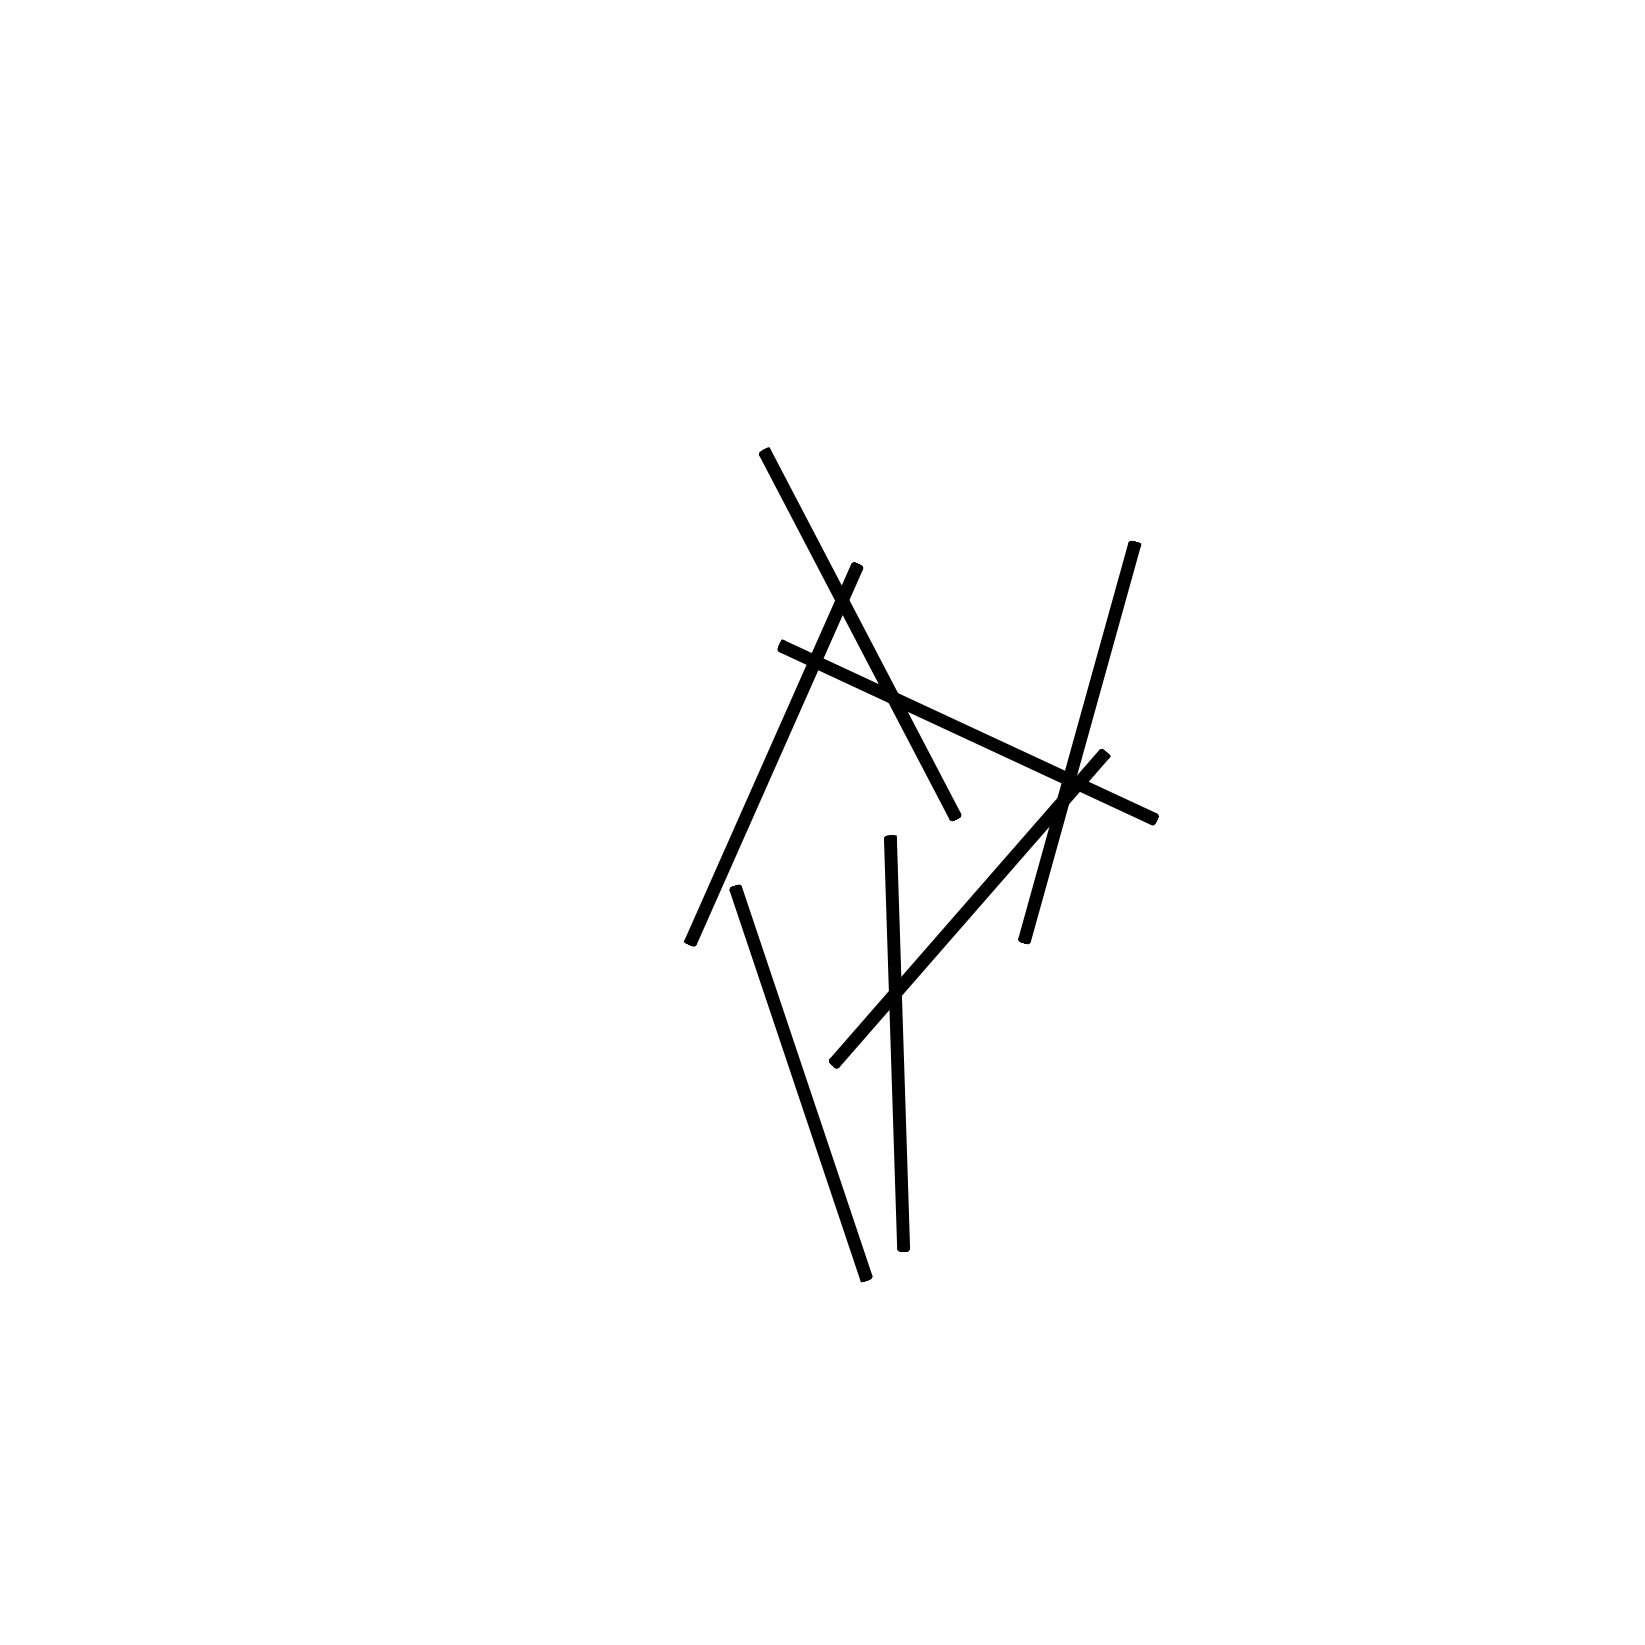

agg phi range:  0.04161175496101759 0.05766769300599536
agg mono phi 0.01
agg mono phi 0.01
agg mono phi 0.01
ar 1.012757268325702 Ap 278.50083131900783 Ac 274.99267596413057 P 68.35079211712403
C 0.4076386590488911


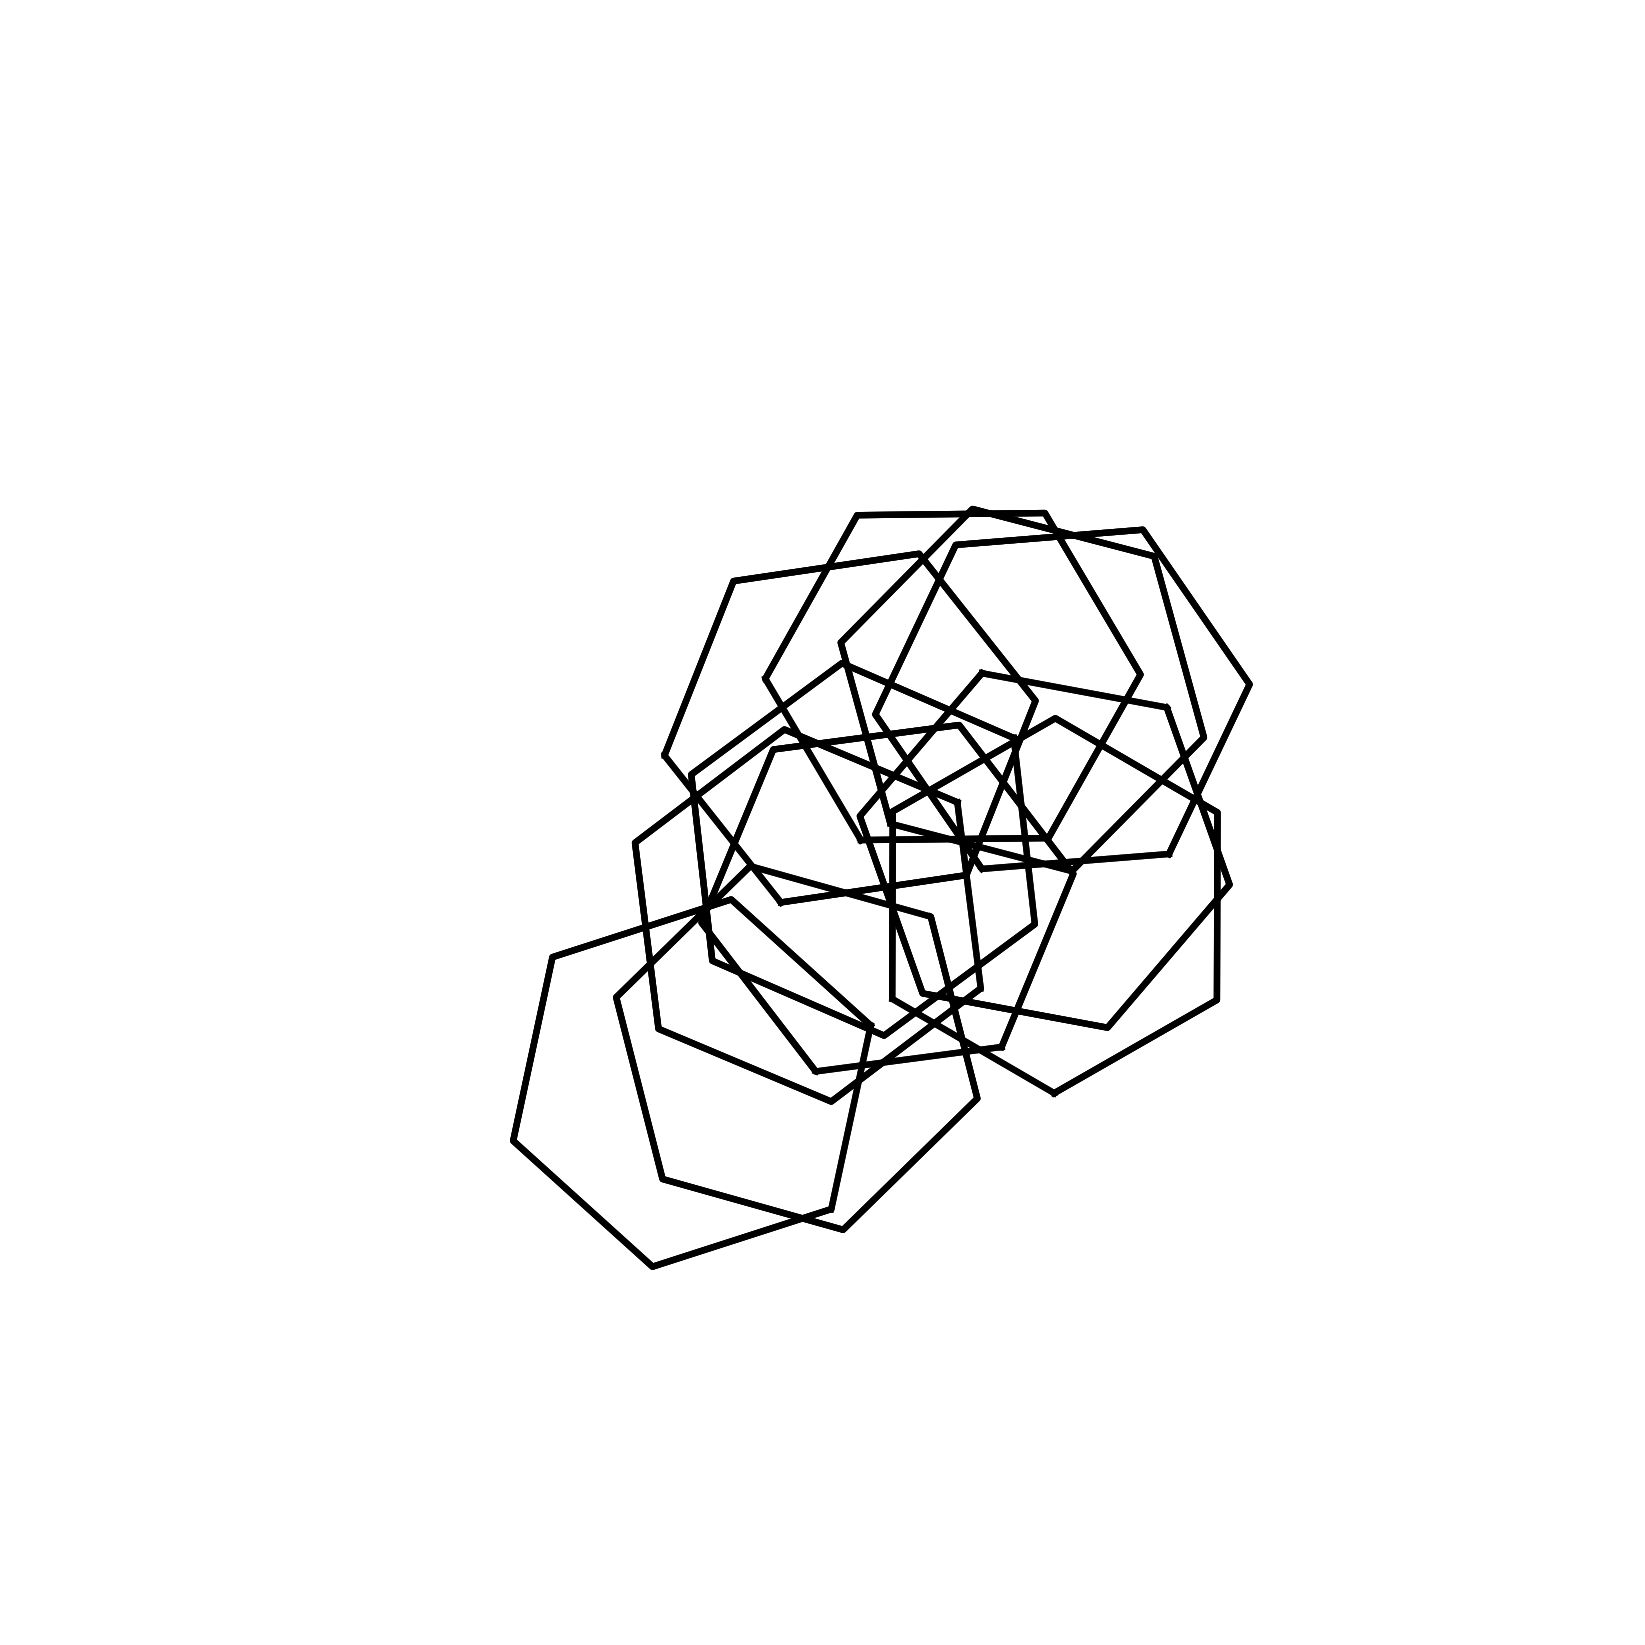

ar 0.7501993999643708 Ap 1431.0581133841604 Ac 1907.5703252390306 P 158.82302028578167
C 0.34499892491974965


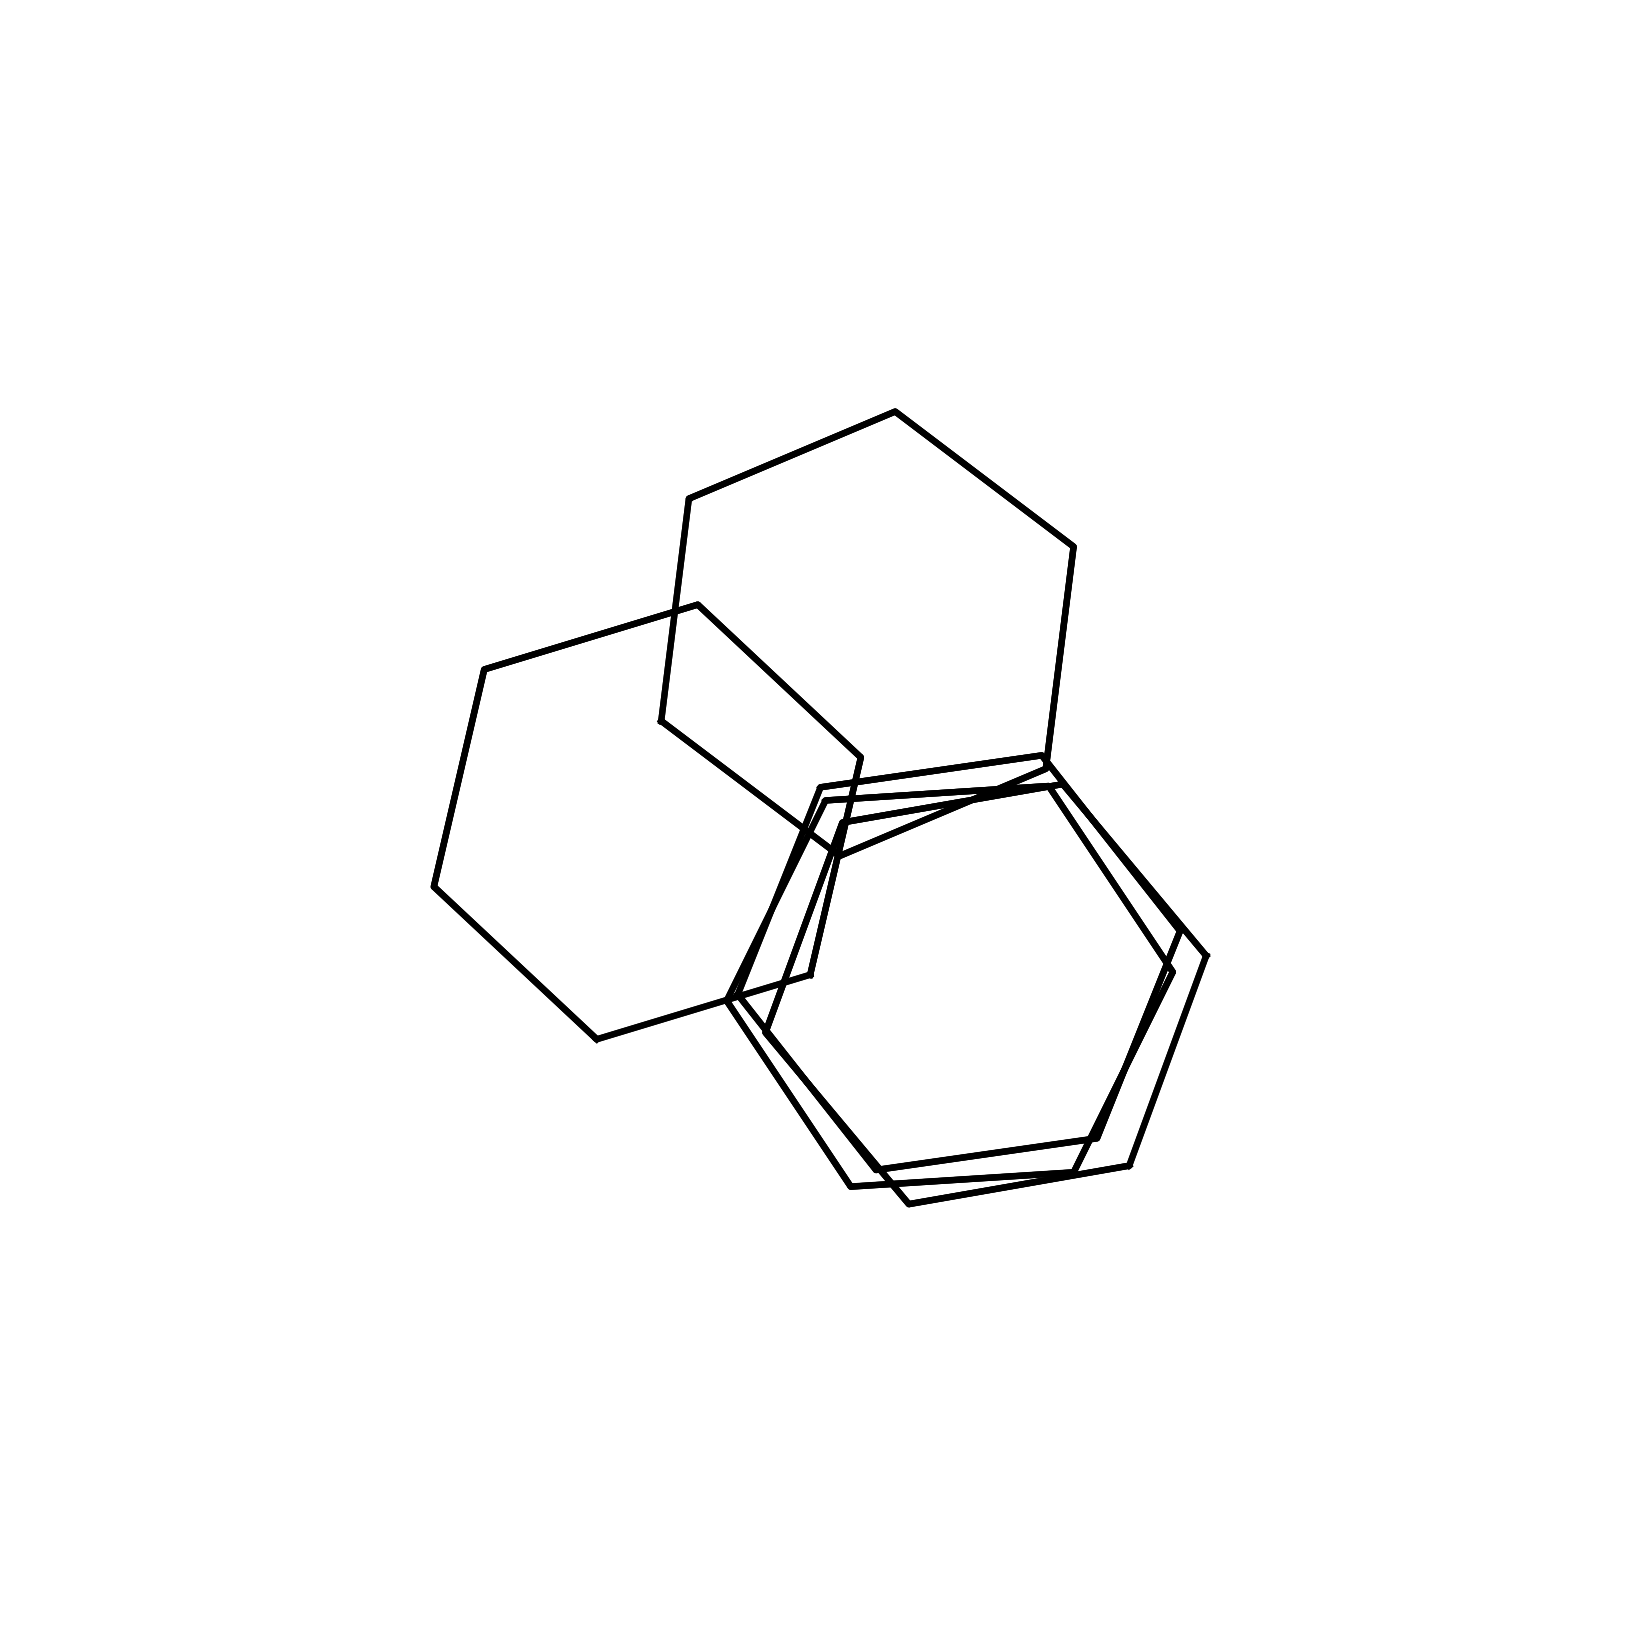

ar 0.7107293127794498 Ap 996.079074970572 Ac 1401.4886639122913 P 194.42121928682033
C 0.6874249004325496


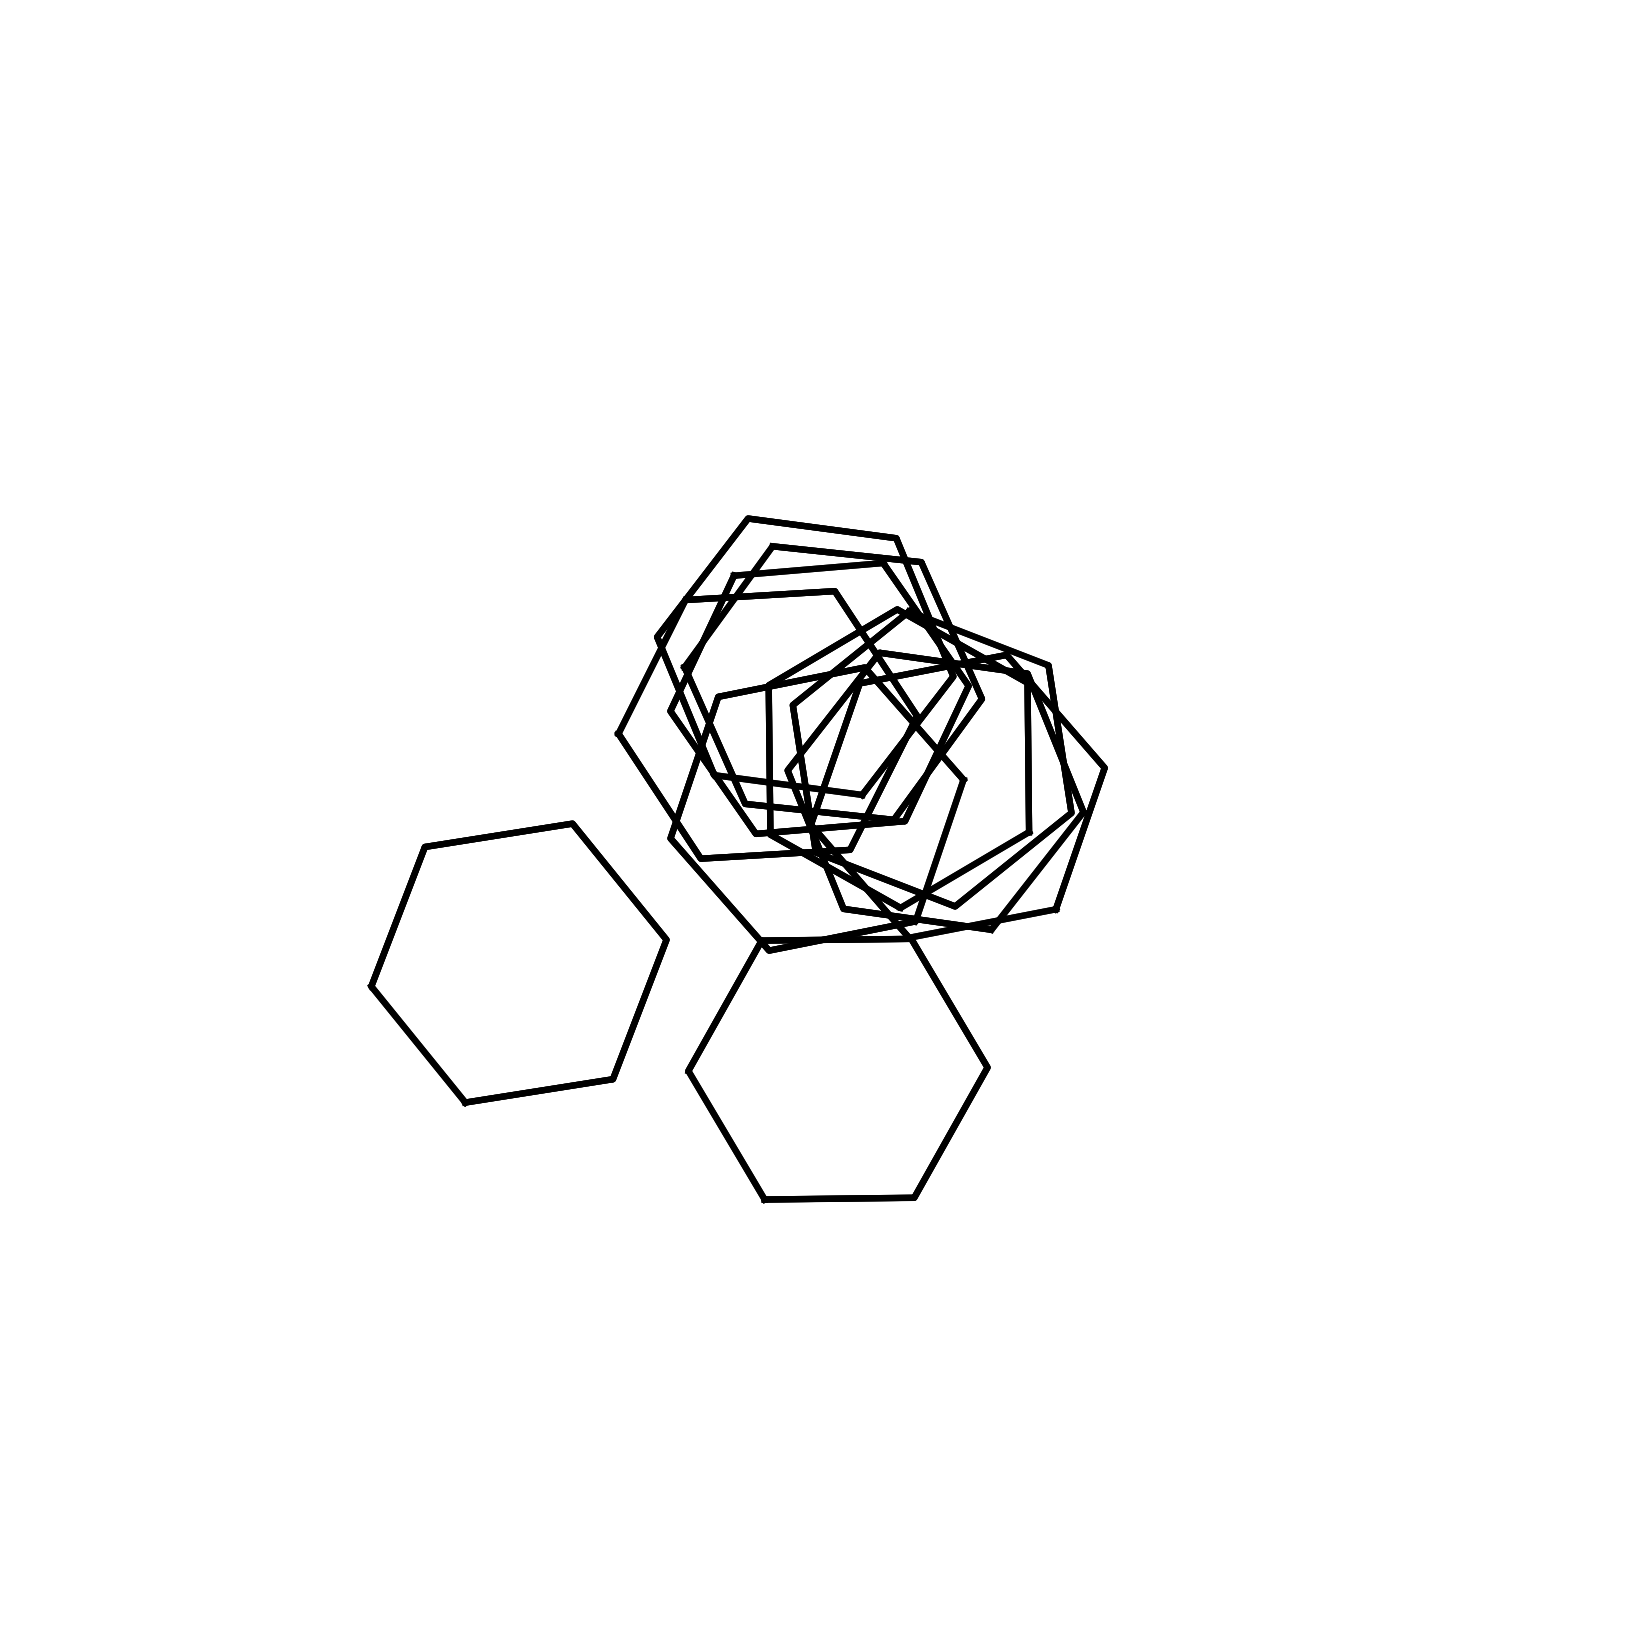

agg phi range:  0.0770390450905301 0.10062840638744733
agg mono phi 0.026366508987303583
agg mono phi 14.38449888287663
agg mono phi 0.016237767391887217
ar 0.7376346766675579 Ap 359.8167664896493 Ac 487.7980630129919 P 79.84668055122098
C 0.34287649511543367


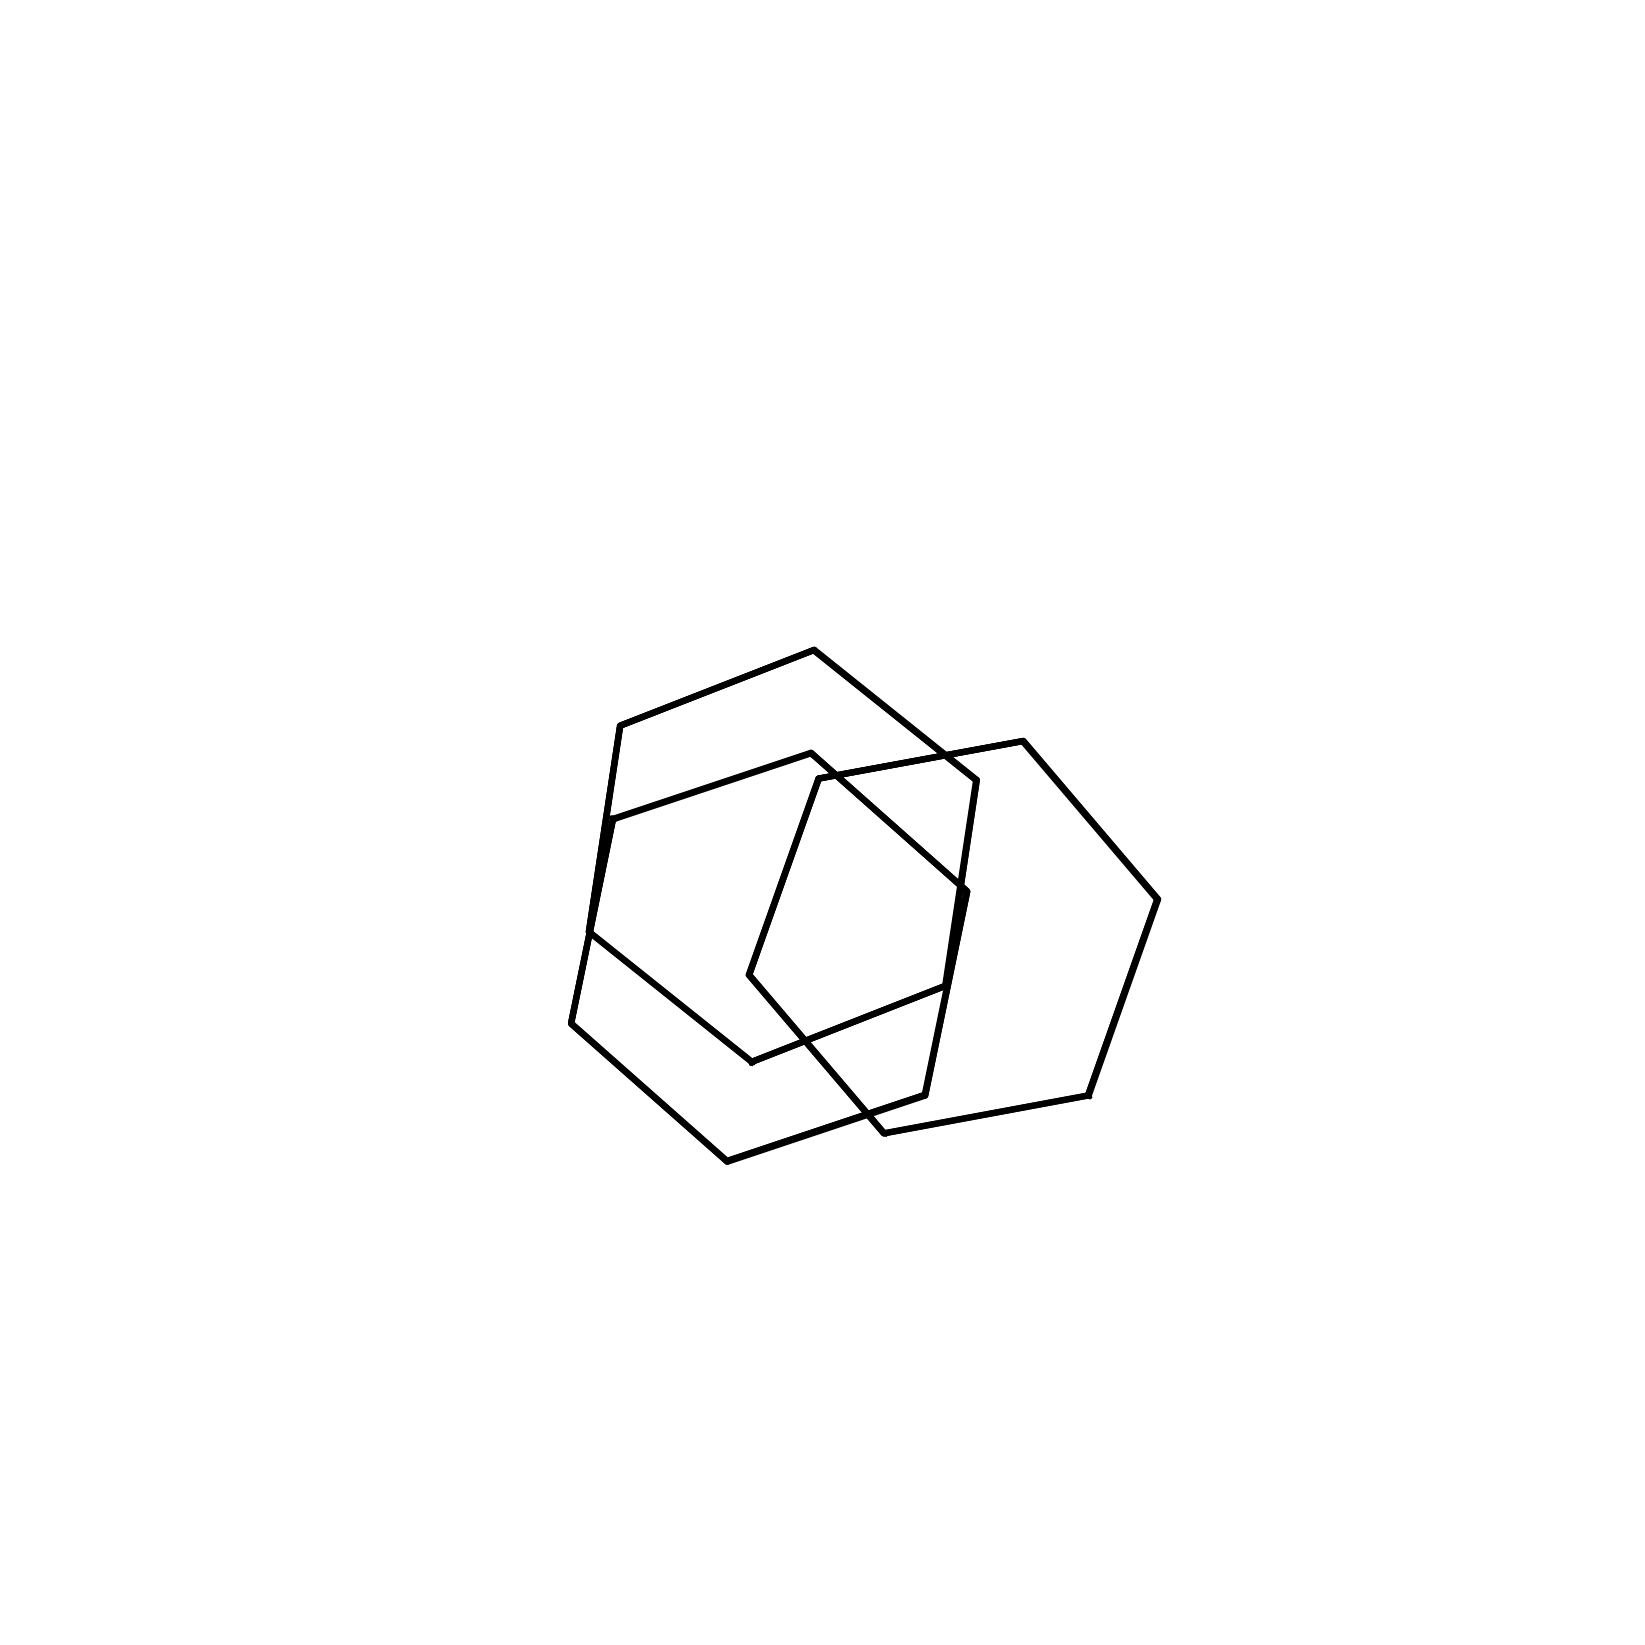

ar 0.3436371741456472 Ap 77.26019574062423 Ac 224.8307271549098 P 175.83513754212134
C 0.9573720543254737


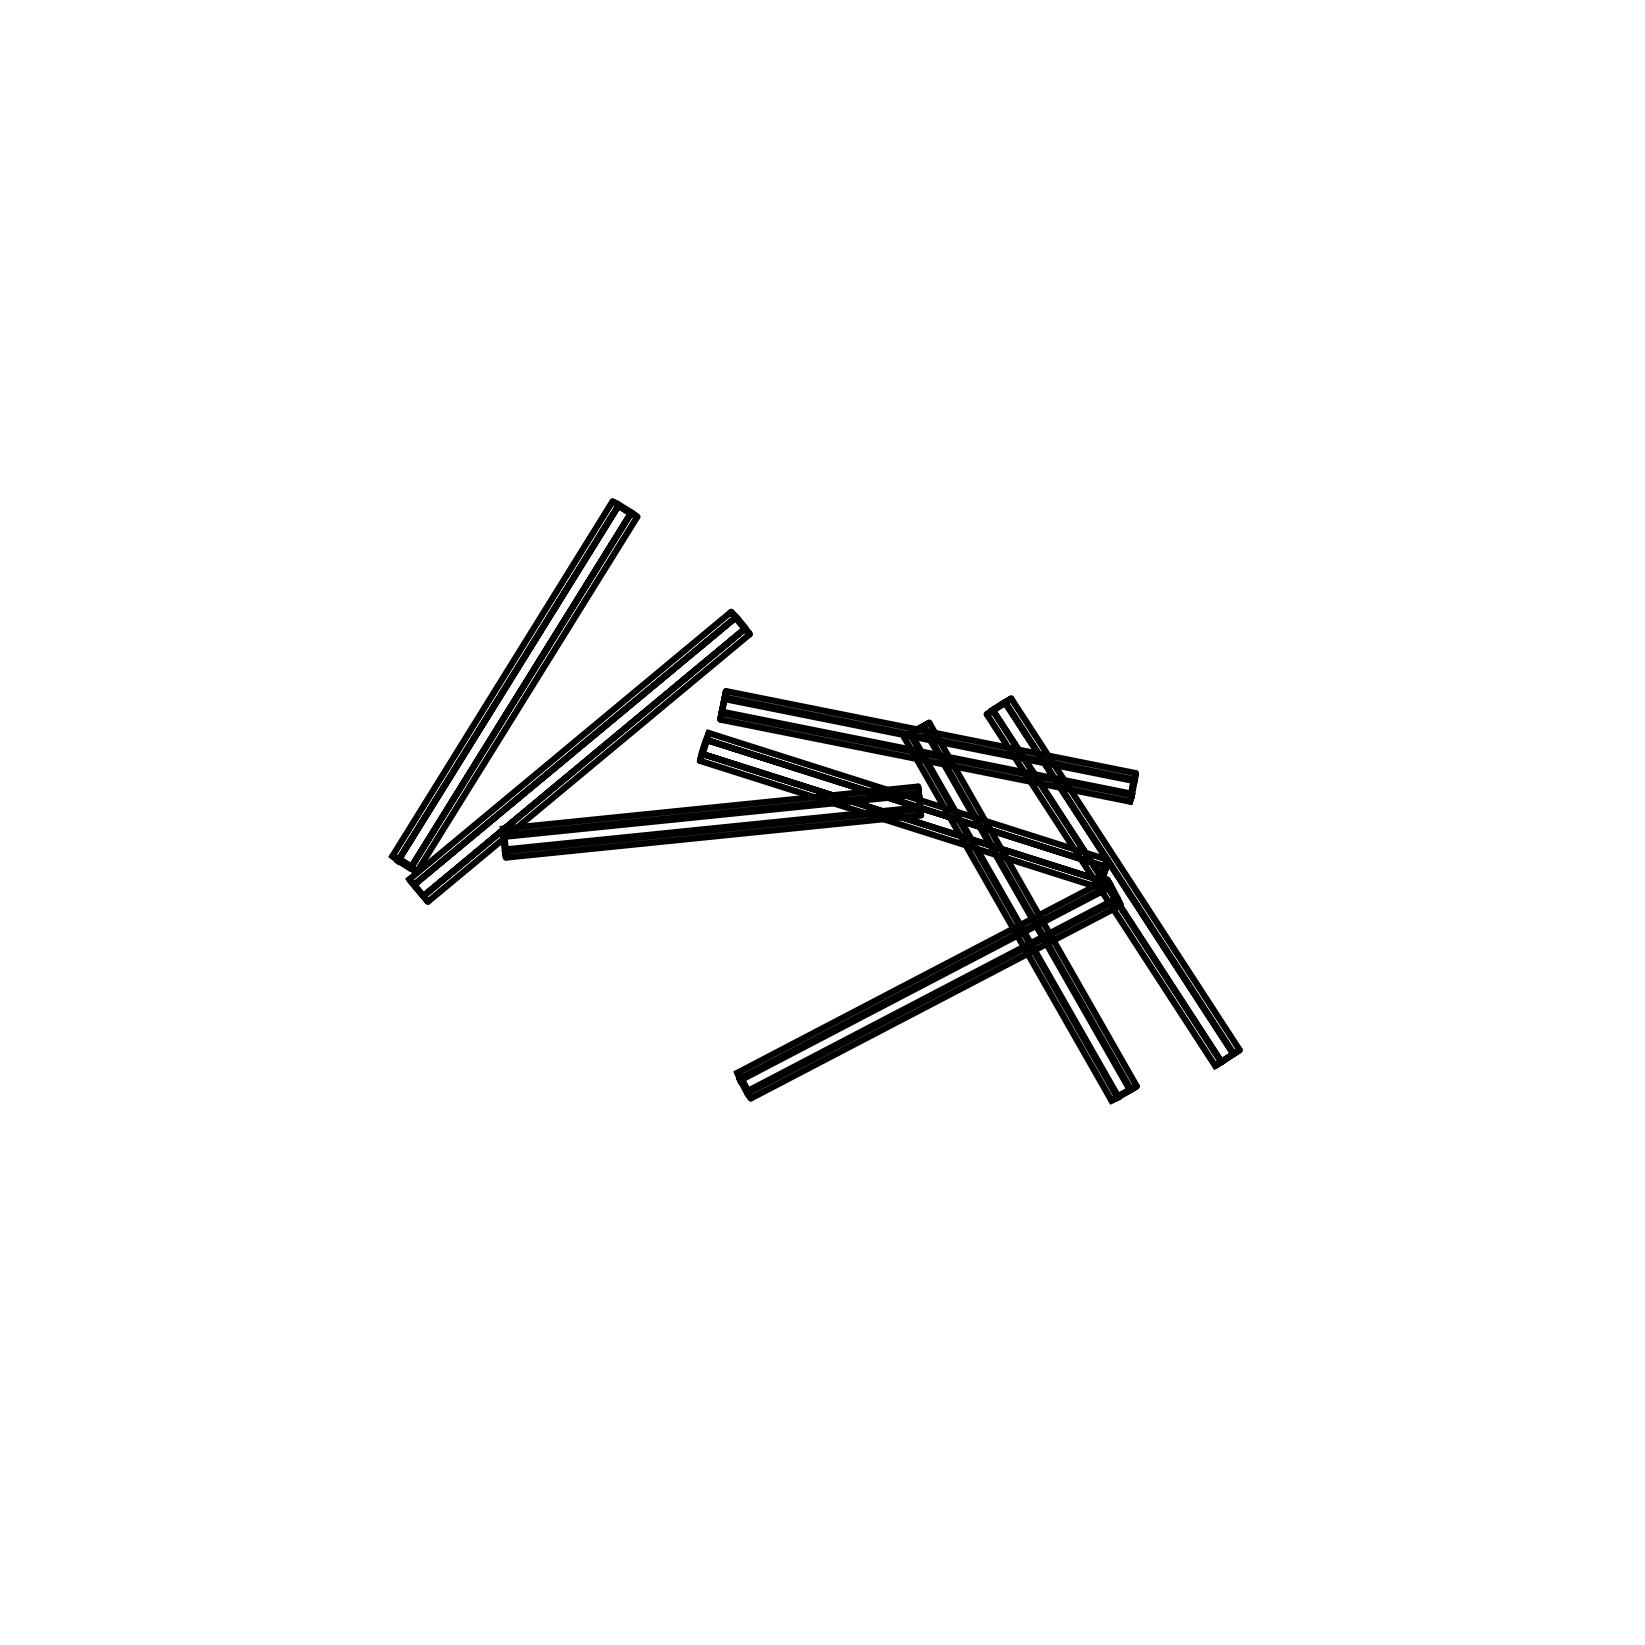

ar 0.5523570498604207 Ap 637.2750674857585 Ac 1153.7375464779466 P 220.42814336857688
C 0.8235251214849628


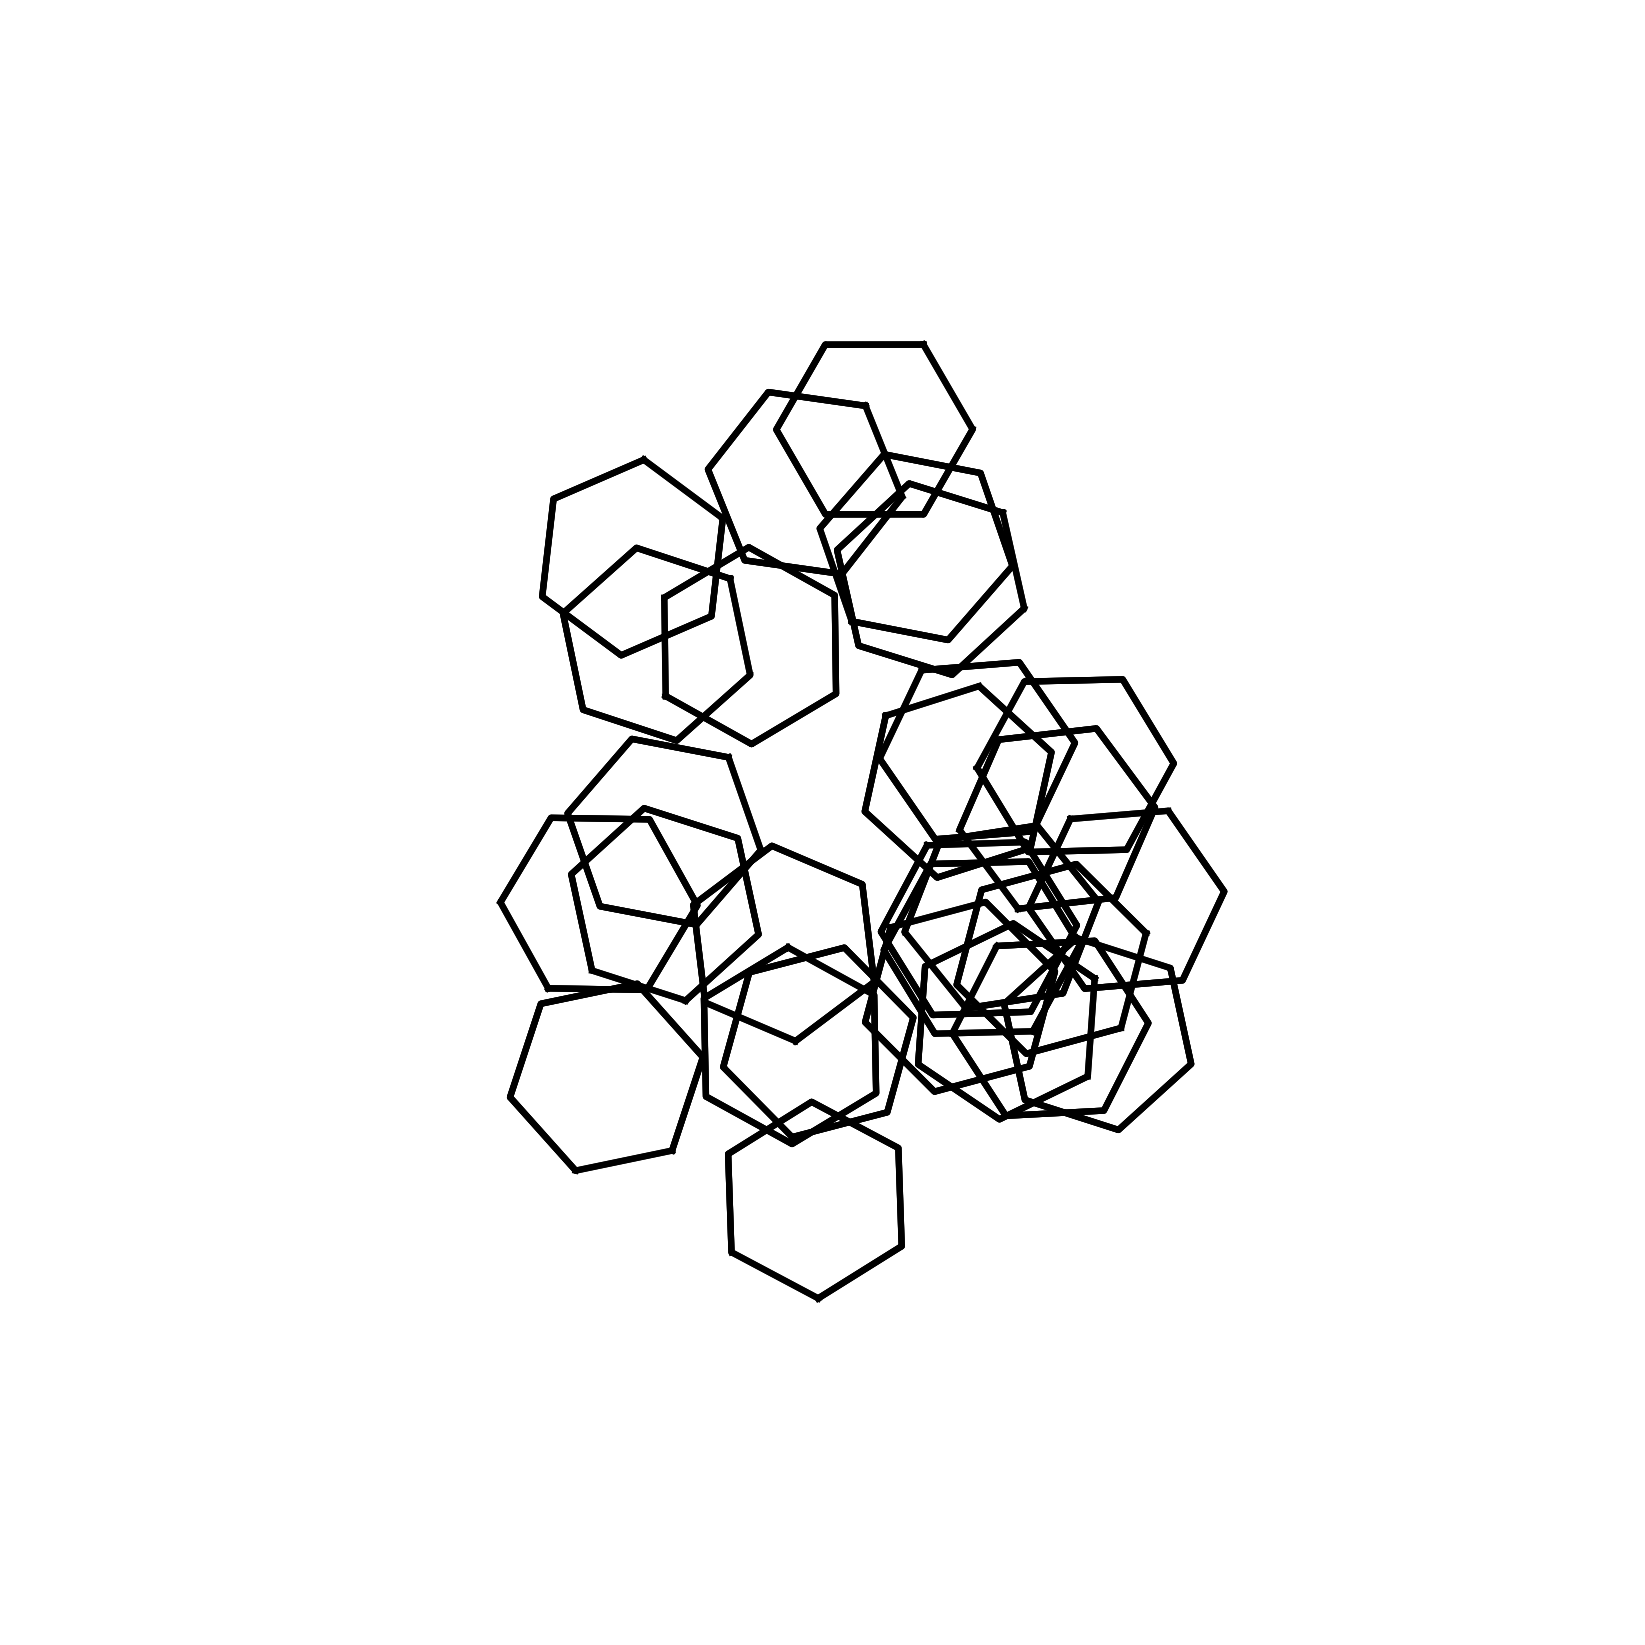

agg phi range:  0.12744013124723563 0.15827041045812382
agg mono phi 0.11288378916846889
agg mono phi 0.016237767391887217
agg mono phi 14.38449888287663
ar 0.8706156072782559 Ap 1124.1524186309612 Ac 1291.2155596949606 P 135.5713694358992
C 0.34449499945261375


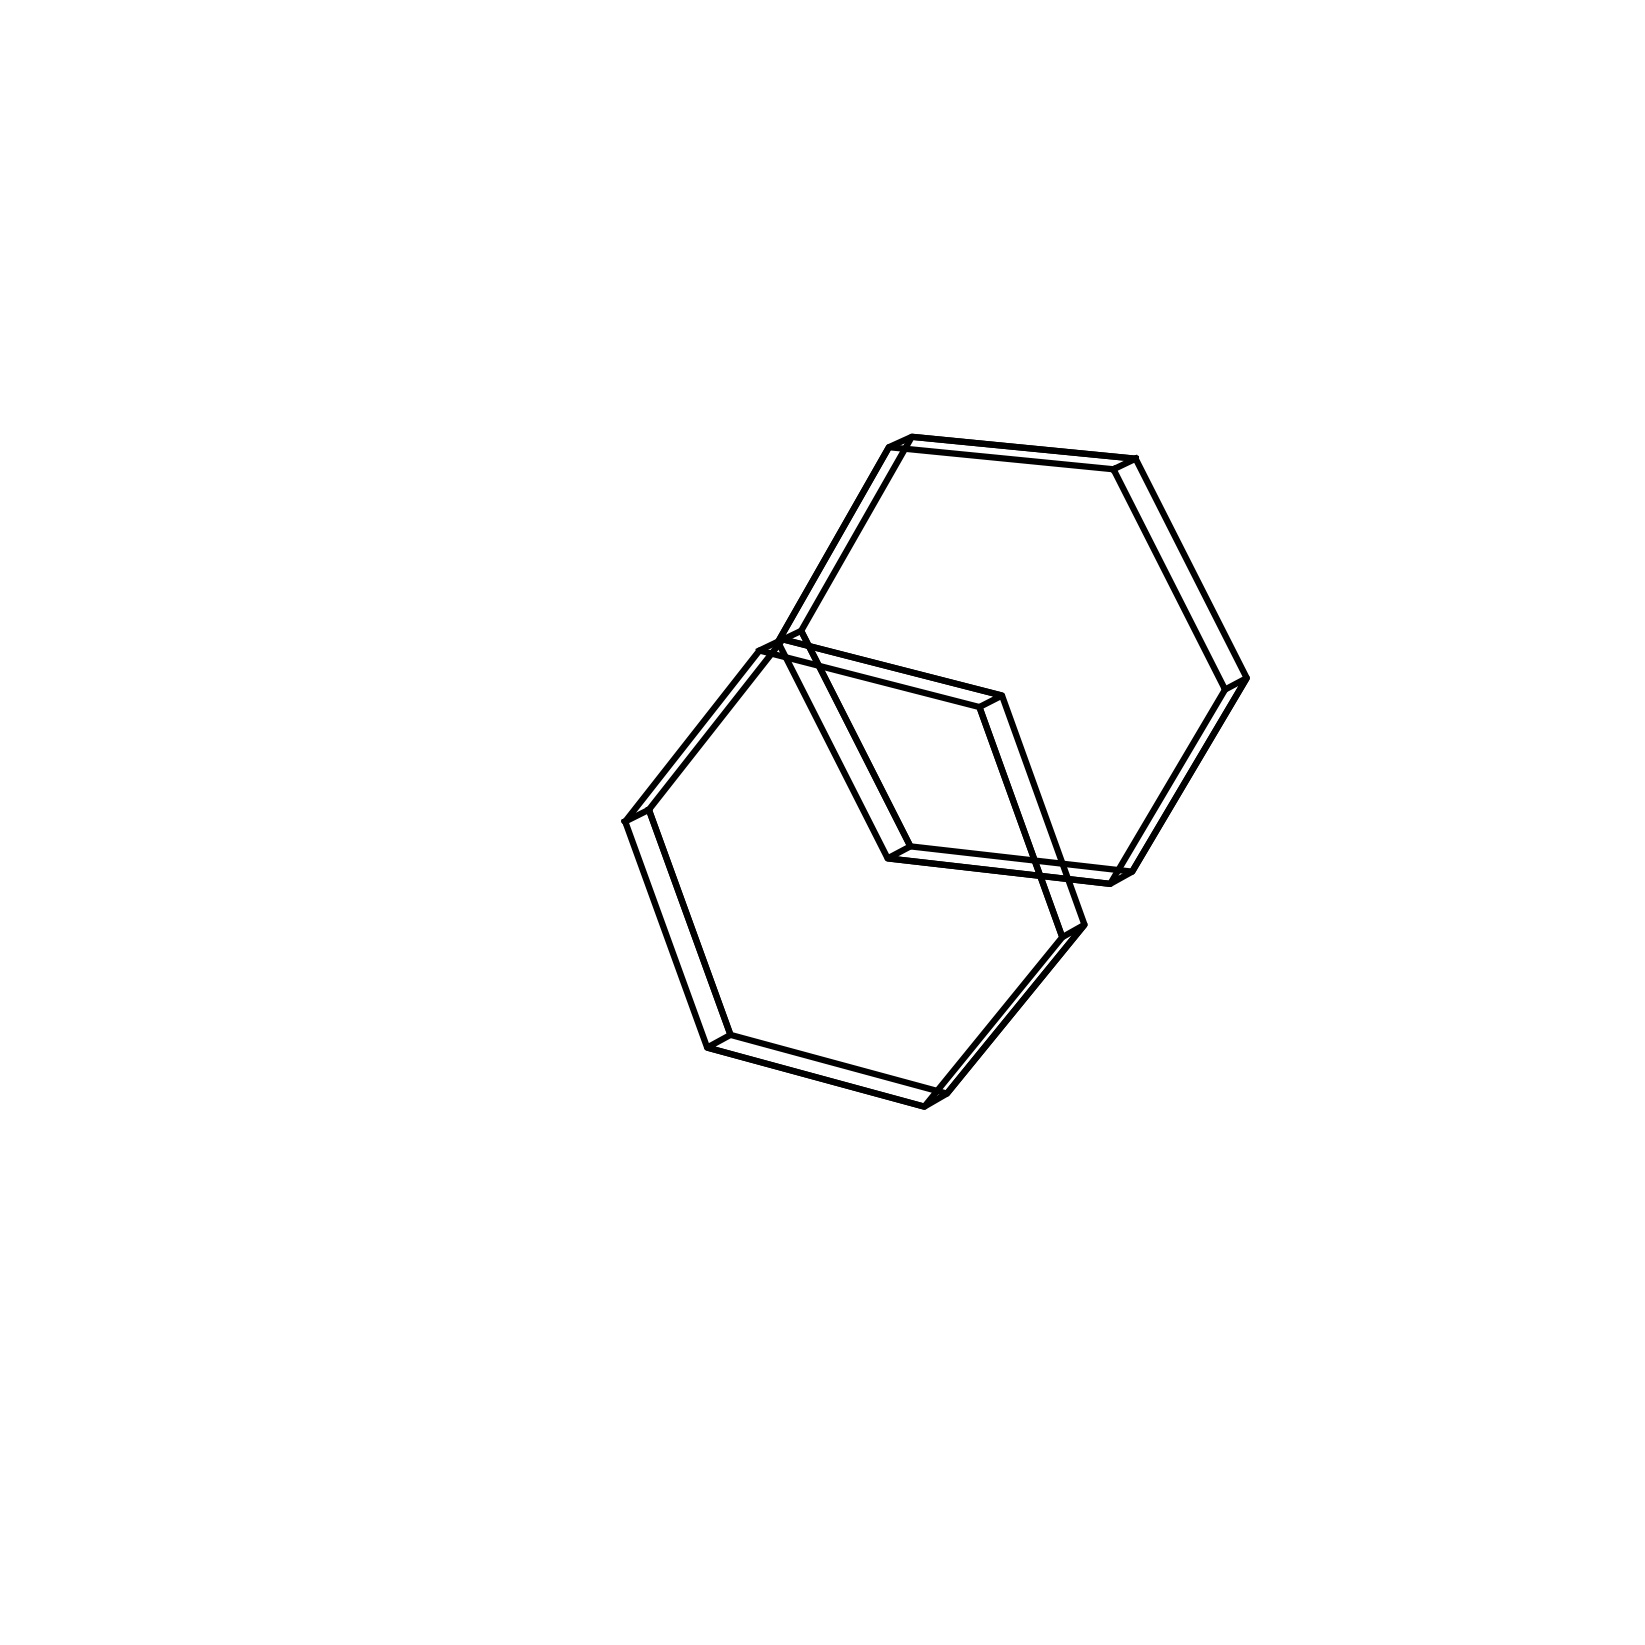

ar 0.7197550576856447 Ap 342.5388273310521 Ac 475.91027485444505 P 90.11990319263181
C 0.5028630873828619


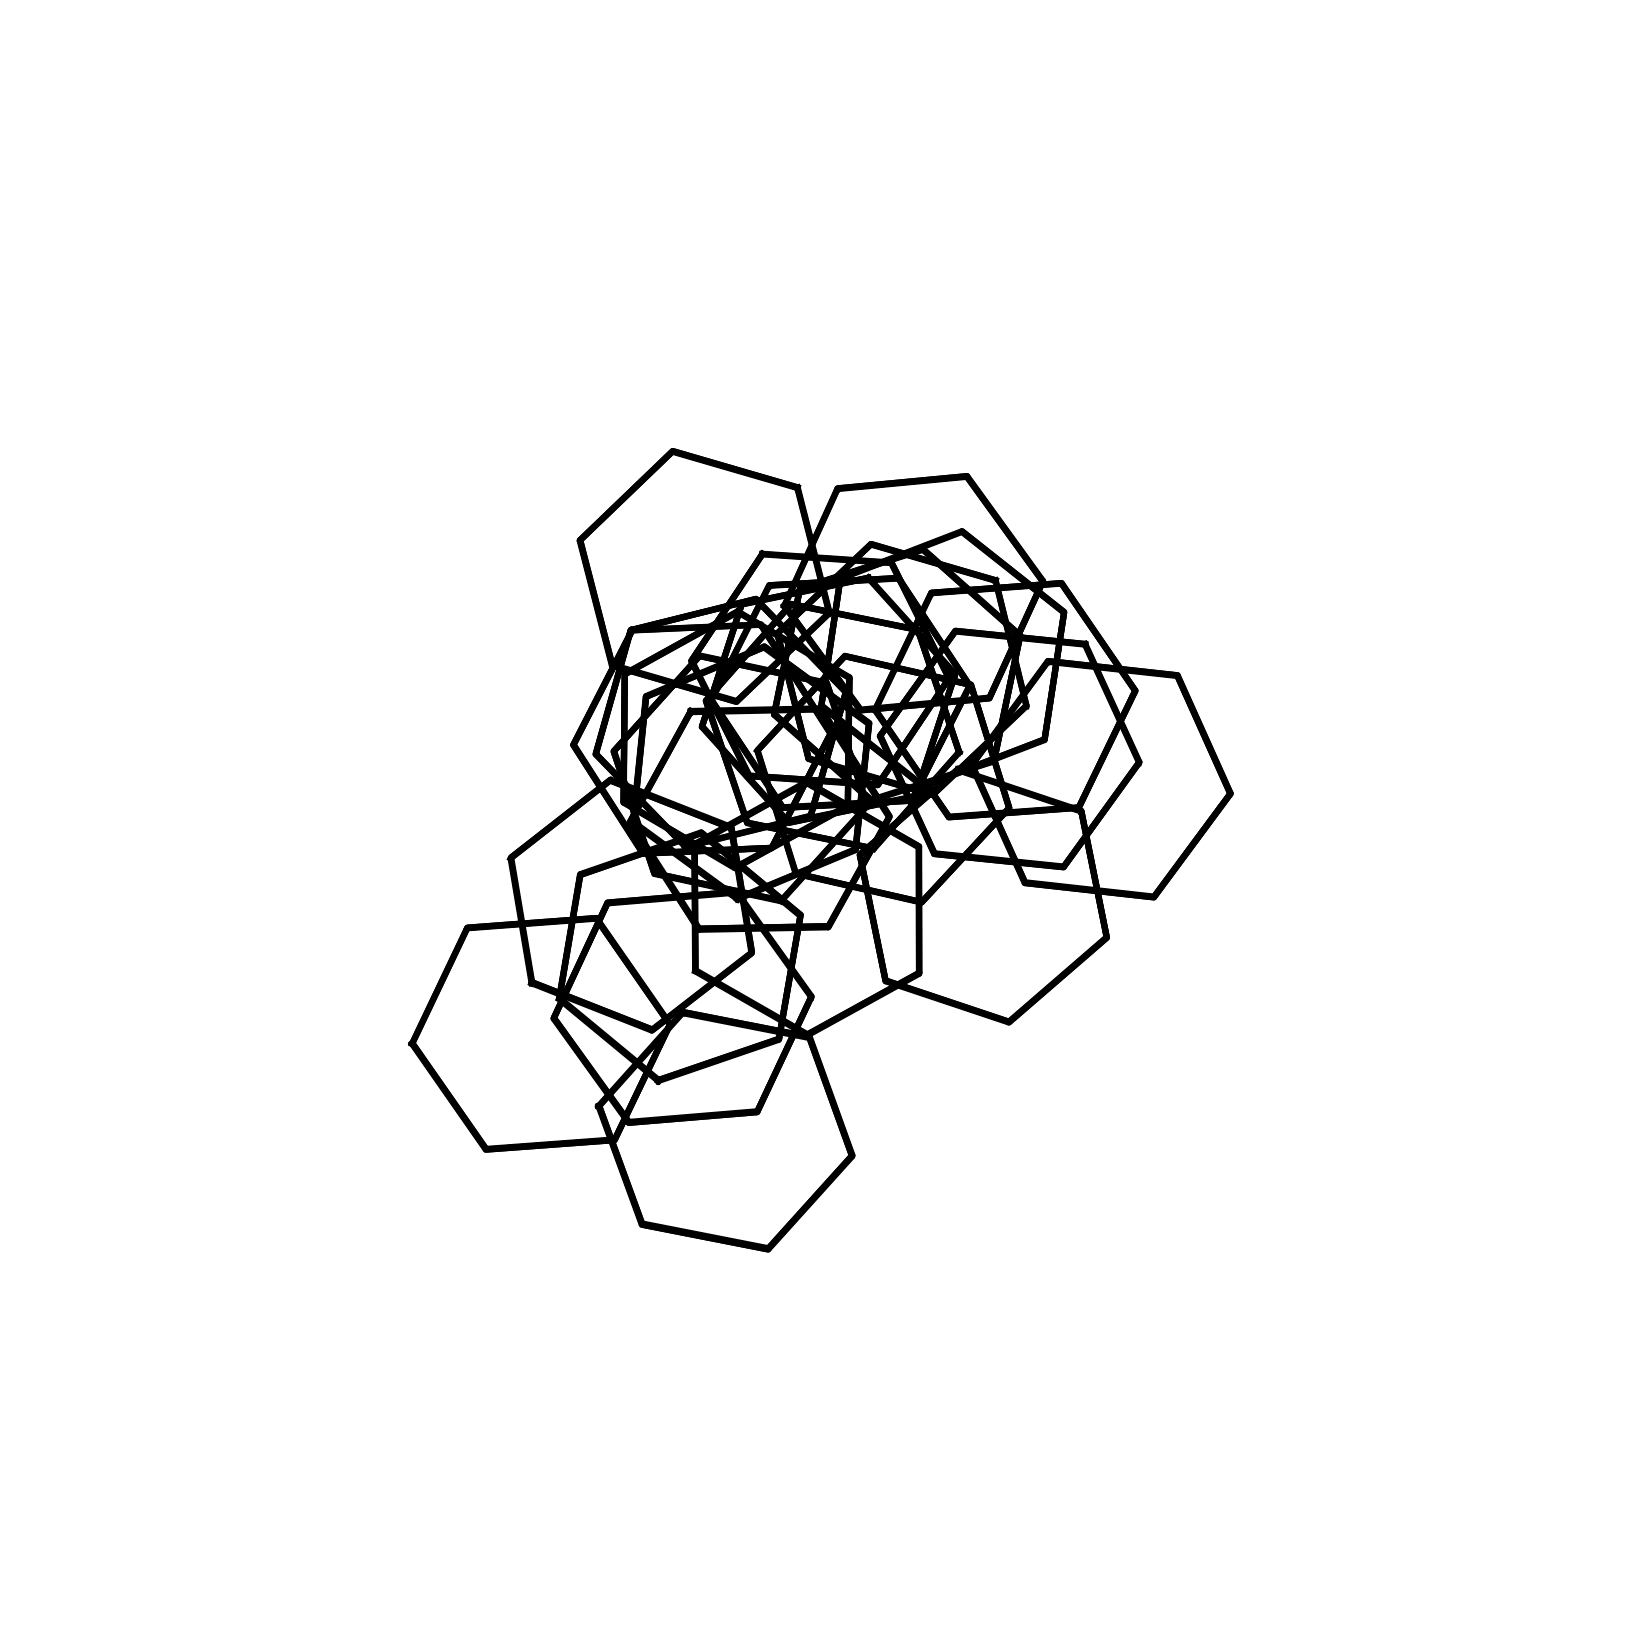

ar 0.3122285754948155 Ap 597.6479789452407 Ac 1914.1360716202753 P 379.6066369805368
C 0.9257764815649854


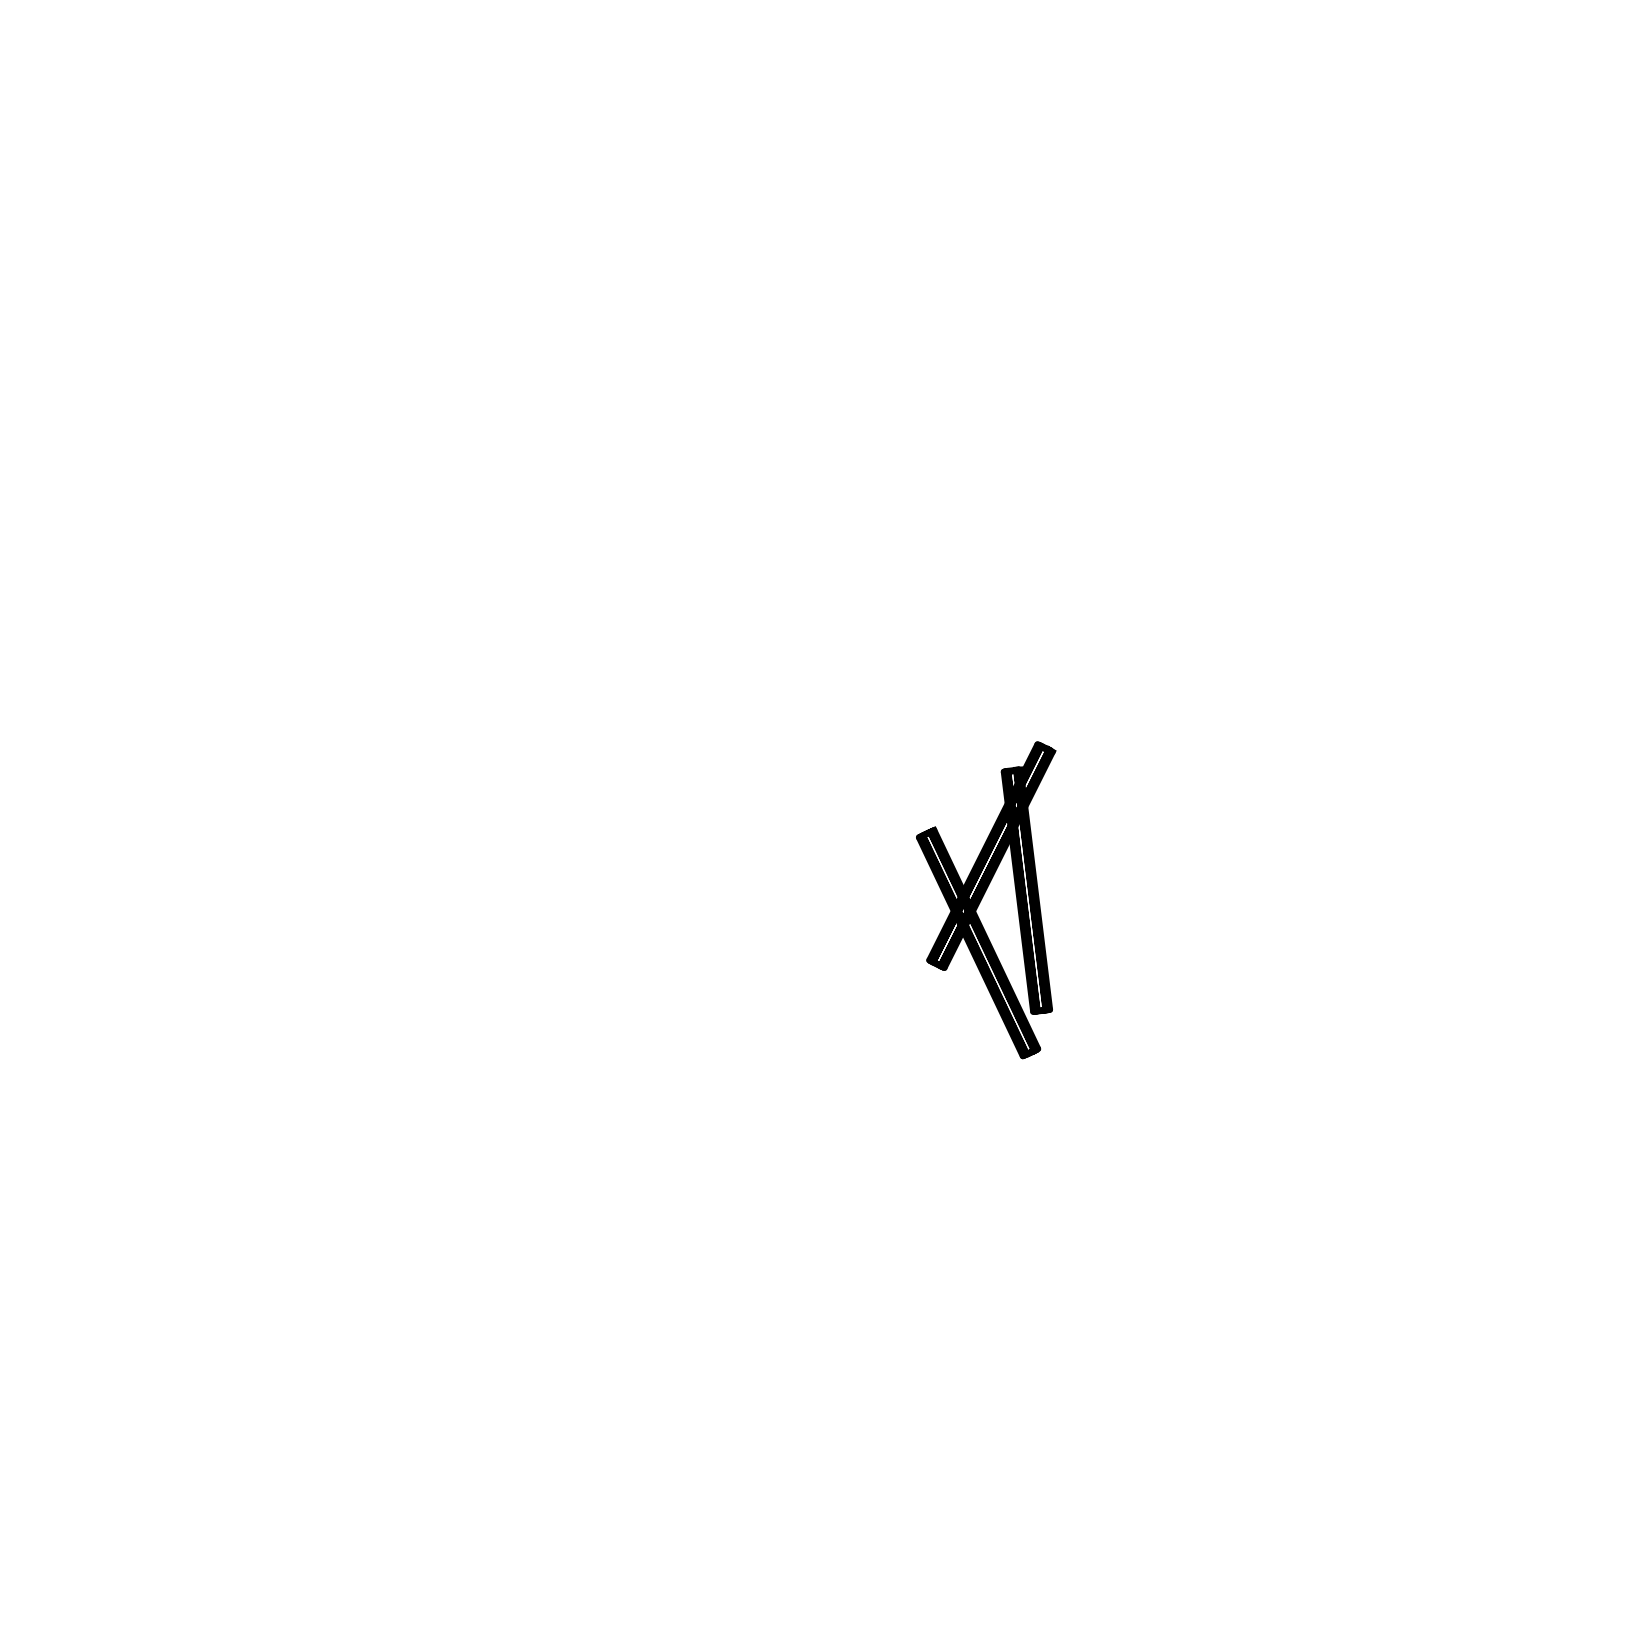

agg phi range:  0.1942899995655651 0.23662032005812247
agg mono phi 8.858667904100823
agg mono phi 14.38449888287663
agg mono phi 0.04281332398719394
ar 0.27493762295177687 Ap 41.185620386831395 Ac 149.79987076579627 P 82.43776966610486
C 0.8844217649093377


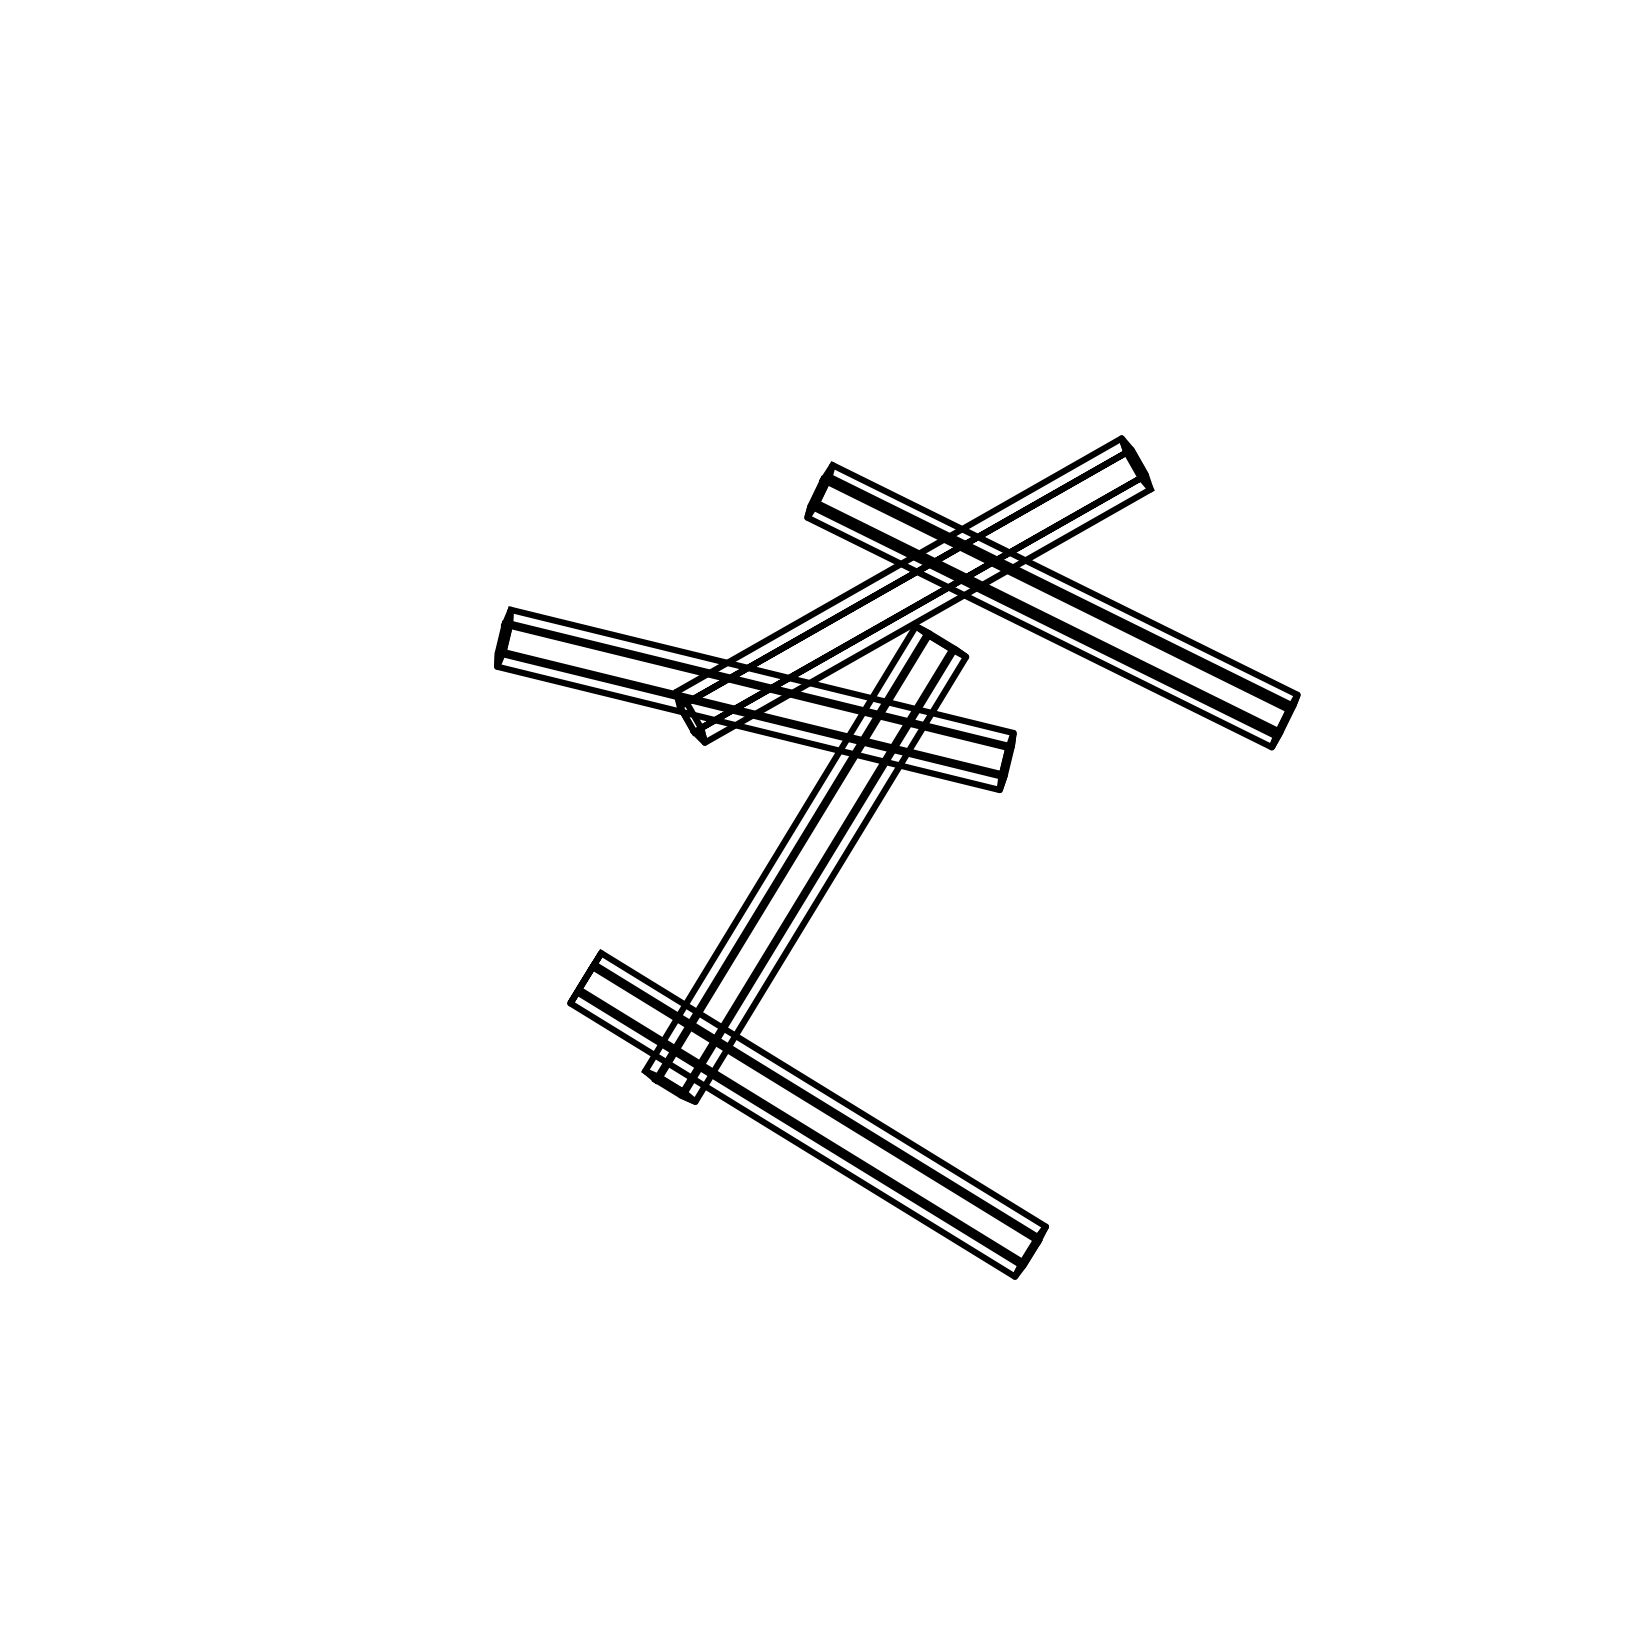

KeyboardInterrupt: 

In [41]:
if __name__ == '__main__':
    
    output, hold_clusters = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= compute()
    results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs, 'phi2Ds':phi2Ds, \
               'cplxs':cplxs, 'dds':dds}


In [ ]:
filename = '../instance_files/pulled_clusters_iceagg_rand'
filehandler = open(filename, 'wb')
pickle.dump(hold_clusters, filehandler)
filehandler.close()
print('finished!')

filename = '../instance_files/instance_db_iceagg_rand'
filehandler = open(filename, 'wb')
pickle.dump(results, filehandler)
filehandler.close()
print('finished!')

## LOAD DATA

In [ ]:
f = open('../instance_files/instance_db_iceagg_flat', 'rb')
results = pickle.load(f)
agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= \
                results['agg_as'], results['agg_bs'], results['agg_cs'], results['phi2Ds'], results['cplxs'], results['dds']
f.close()

f = open('../instance_files/pulled_clusters_iceagg_flat', 'rb')
pulled_clus = pickle.load(f)
f.close()

In [ ]:
pos = np.sum(dds >= 0)
neg = np.sum(dds <= 0)
pos/neg

In [ ]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df_r.ncrystals.mean())
    return avg_ncrystals


In [ ]:
def avg_cplx(df_phi, r_bins):
    avg_cplx = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_cplx.append(np.mean(df_r.cplx))
        
    return avg_cplx


In [ ]:
def oblate_prolate(df_phi, r_bins):
    oblates = []
    prolates = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        oblate = df_r['shape'][df_r['shape'] == 'oblate'].count()
        prolate = df_r['shape'][df_r['shape'] == 'prolate'].count()
        oblates.append(oblate)
        prolates.append(prolate)
    return oblates, prolates

In [ ]:
def plate_columns_agg(df_phi, r_bins):
    agg_mono_phi = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        agg_mono_plates = df_r['mono_phi'][df_r['mono_phi'] < 1.0].count()
        agg_mono_col = df_r['mono_phi'][df_r['mono_phi'] > 1.0].count()
        #agg_mono_phi.append(agg_mono_plates - agg_mono_col)
        agg_mono_phi.append(agg_mono_plates/(agg_mono_plates+agg_mono_col)*100)
    return agg_mono_phi


In [ ]:
def average_radius(df_phi, r_bins):
    avg_radius = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_radius.append(np.mean(df_r.mono_r))
    return avg_radius

In [ ]:
df = df_flat
res, phi_bins = pd.qcut(df['agg_phi'], 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_cplxs=np.empty((len(phi_bins)-1,len(phi_bins)-1))
all_r_bins= np.empty((len(phi_bins),len(phi_bins)))
oblates= np.empty((len(phi_bins)-1,len(phi_bins)-1))
prolates= np.empty((len(phi_bins)-1,len(phi_bins)-1))
shape= np.empty((len(phi_bins)-1,len(phi_bins)-1))
agg_mono_phi = np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_radius = np.empty((len(phi_bins)-1,len(phi_bins)-1))

for i in range(agg_phi_bins):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f)' %(phi_bins[i],phi_bins[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df[(df['agg_phi'] > phi_bins[i]) & (df['agg_phi'] < phi_bins[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r, 20, retbins=True)
    all_r_bins[i,:] = r_bins
    
    #now use those r bins from the output of queried r and phi to find # of monomers per bin
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins)
    avg_cplxs[i,:] = avg_cplx(df_phi, r_bins)
    oblates[i,:], prolates[i,:] = oblate_prolate(df_phi, r_bins)
    shape[i,:] = oblates[i,:]-prolates[i,:]
    agg_mono_phi[i,:] = plate_columns_agg(df_phi, r_bins)
    avg_radius[i,:] = average_radius(df_phi, r_bins)
    

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
cmap_ob = plt.cm.Reds
cmap_pro = plt.cm.Blues
variable1 = oblates
variable2 = prolates
norm1 = matplotlib.colors.Normalize(vmin=min(np.amin(variable1),np.amin(variable2)), vmax=max(np.amax(variable2), np.amax(variable1)))
norm2 = matplotlib.colors.Normalize(vmin=min(np.amin(variable2),np.amin(variable1)), vmax=max(np.amax(variable2), np.amax(variable1)))
#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))

width=1.2
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
 
        if r != 0:
            plt.bar(i*3, all_r_bins[i,r], width=width, bottom= all_r_bins[i,r-1], color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')
        else:
            plt.bar(i*3, all_r_bins[i,r], width=width, color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')

for i in range(agg_phi_bins): 
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, bottom= all_r_bins[i,r-1], color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')
        else:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')

            
plt.yscale('log')
plt.xticks((np.arange(20)*3)+width/2, phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax)

# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cax2 = divider.append_axes("right", size="5%", pad=1.)


cb1 = cm.ScalarMappable(norm=norm1, cmap=cmap_ob)
cbar1 = plt.colorbar(cb1, format='%d')
cb2 = cm.ScalarMappable(norm=norm2, cmap=cmap_pro)
cbar2 = plt.colorbar(cb2,format='%d')

cbar1.ax.set_ylabel('# of Oblates per Bin', fontsize=16, family='serif')
cbar2.ax.set_ylabel('# of Prolates per Bin', fontsize=16, family='serif')
plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
#plt.title('Random Orientation',fontsize=16, family='serif')
#plt.tight_layout()
#plt.savefig('bins_flat_shape.eps')


In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
cmap_ob = plt.cm.Reds
cmap_pro = plt.cm.Blues
variable1 = oblates
variable2 = prolates
norm1 = matplotlib.colors.Normalize(vmin=min(np.amin(variable1),np.amin(variable2)), vmax=max(np.amax(variable2), np.amax(variable1)))
norm2 = matplotlib.colors.Normalize(vmin=min(np.amin(variable2),np.amin(variable1)), vmax=max(np.amax(variable2), np.amax(variable1)))
#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))

width=1.2
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
 
        if r != 0:
            plt.bar(i*3, all_r_bins[i,r], width=width, bottom= all_r_bins[i,r-1], color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')
        else:
            plt.bar(i*3, all_r_bins[i,r], width=width, color=cmap_ob(norm1(variable1[i,r])), edgecolor='k')

for i in range(agg_phi_bins): 
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, bottom= all_r_bins[i,r-1], color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')
        else:
            plt.bar((i*3)+width, all_r_bins[i,r],width=width, color=cmap_pro(norm2(variable2[i,r])), edgecolor='k')

            
plt.yscale('log')
plt.xticks((np.arange(20)*3)+width/2, phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(ax)

# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# cax2 = divider.append_axes("right", size="5%", pad=1.)

cb1 = cm.ScalarMappable(norm=norm1, cmap=cmap_ob)
cbar1 = plt.colorbar(cb1, format='%d')
cb2 = cm.ScalarMappable(norm=norm2, cmap=cmap_pro)
cbar2 = plt.colorbar(cb2,format='%d')

cbar1.ax.set_ylabel('# of Oblates per Bin', fontsize=16, family='serif')
cbar2.ax.set_ylabel('# of Prolates per Bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Random Orientation',fontsize=16, family='serif')
#plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')


In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list1 = base(np.linspace(0, .5, 10))
    color_list2 = base(np.linspace(.5, .8, 4))
    color_list = np.append(color_list1,color_list2)
    color_list =  color_list.reshape(14,4)
    print(color_list)
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
#cmap = plt.cm.RdBu_r
cmap=discrete_cmap(14,'Spectral_r')
variable=agg_mono_phi
# norm = matplotlib.colors.Normalize(vmin=-max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))), \
#                                    vmax=max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))))
norm1 = matplotlib.colors.Normalize(vmin=0, vmax=70)
norm = matplotlib.colors.DivergingNorm(vmin=0, vcenter=50., vmax=70)
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
        if r != 0:
            plt.bar(i, all_r_bins[i,r], bottom= all_r_bins[i,r-1], color=cmap(norm(variable[i,r])), edgecolor='k')
        else:
            plt.bar(i, all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')

plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
# plt.ylabel("Aggregate Radius Bins")
# plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",)  

cb = cm.ScalarMappable(cmap=cmap, norm=norm1)
cbar = plt.colorbar(cb, format='%d')
cbar.set_ticks(np.linspace(0,70,8))
          
#cbar.ax.set_ylabel('# of Oblates per Bin')
#plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation');
#plt.tight_layout()
plt.tight_layout()
#plt.savefig('../plots/bins_rand_monophi.png', format='png',dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
#cmap = plt.cm.RdBu_r
cmap=discrete_cmap(14,'RdBu_r')
variable=agg_mono_phi
# norm = matplotlib.colors.Normalize(vmin=-max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))), \
#                                    vmax=max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))))
norm1 = matplotlib.colors.Normalize(vmin=0, vmax=70)
norm = matplotlib.colors.DivergingNorm(vmin=0, vcenter=50., vmax=70)
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
        if r != 0:
            plt.bar(i, all_r_bins[i,r], bottom= all_r_bins[i,r-1], color=cmap(norm(variable[i,r])), edgecolor='k')
        else:
            plt.bar(i, all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')

plt.yscale('log')
plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
# plt.ylabel("Aggregate Radius Bins")
# plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",)  

cb = cm.ScalarMappable(cmap=cmap, norm=norm1)
cbar = plt.colorbar(cb, format='%d')
cbar.set_ticks(np.linspace(0,100,11))
          
#cbar.ax.set_ylabel('# of Oblates per Bin')
#plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation');
#plt.tight_layout()
plt.tight_layout()
#plt.savefig('../plots/bins_flat_monophi.png', format='png',dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.Spectral_r
cmap=discrete_cmap(15,'Spectral_r')

variable=agg_mono_phi
# norm = matplotlib.colors.Normalize(vmin=-max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))), \
#                                    vmax=max(abs(np.amin(agg_mono_phi)),abs(np.amax(agg_mono_phi))))
#norm = matplotlib.colors.Normalize(vmin=-9237, vmax=9237)
norm = matplotlib.colors.Normalize(vmin=0, vmax=90)
bounds = np.linspace(0, 100, 11)
norm = matplotlib.colors.DivergingNorm(vmin=0, vcenter=50., vmax=70)
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):  
        if r != 0:
            plt.bar(i, all_r_bins[i,r], bottom= all_r_bins[i,r-1], color=cmap(norm(variable[i,r])), edgecolor='k')
        else:
            plt.bar(i, all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')

plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
# plt.ylabel("Aggregate Radius Bins")
# plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",)  

cb = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%d')

#cbar.ax.set_ylabel('# of Oblates per Bin')
#plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation');
#plt.tight_layout()
plt.tight_layout()
plt.savefig('../plots/bins_rand_monophi.png', format='png',dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.jet
variable = avg_radius
norm = matplotlib.colors.LogNorm(vmin=1.13, vmax=672)

#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
plt.yscale('log')
plt.ylim(1.,10000)

#plt.xticks([])
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
#plt.ylabel("Aggregate Radius Bins")

#plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins") 
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cb, orientation='vertical')
#cbar.ax.set_ylabel('Average Monomer Radius per Bin', orientation='horizontal')
#plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
plt.savefig('../plots/bins_flat_meanmono_r.png', format='png', dpi=300)


In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.jet
variable = avg_ncrystals
norm = matplotlib.colors.Normalize(vmin=2, vmax=25)
bounds = np.linspace(0, 25, 26)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r]),10),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r]),10), edgecolor='k')
    
plt.yscale('log')
plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
#plt.ylabel("Aggregate Radius Bins")
#plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cb, orientation='vertical', ticks=np.linspace(0, 26, 14))
#cbar.ax.set_ylabel('Average # of Monomers per Bin')
#plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
plt.savefig('../plots/bins_flat_meanmono_ncrys.png', format='png', dpi=300)


In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
cmap = plt.cm.jet
variable = avg_cplxs
norm = matplotlib.colors.Normalize(vmin=0.4, vmax=1.0)
bounds = np.linspace(0.4, 1.0, 11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):
        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r]), 10),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r]), 10), edgecolor='k')

plt.yscale('log')
plt.ylim(1.,10000)
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center")
#plt.ylabel("Aggregate Radius Bins")
#plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins")  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cb, orientation='vertical')
#plt.title('Quasi-Horizontal Orientation')
#plt.title('Random Orientation')
plt.tight_layout()
plt.savefig('../plots/bins_flat_meancplx.png', format='png', dpi=300)
